Initial model testing: 

Now that exploratory data analysis is complete, a variety of gradient boosted models can be used on the initial dataset (application_train) to get an idea of model performance and feature engineering before joining all tables.


Importing necessary packages: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (HistGradientBoostingClassifier)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
from catboost import CatBoostClassifier
from sklearn.inspection import permutation_importance

import sys
import os

sys.path.append(os.path.abspath('../functions'))
from functions import  get_missing_df_info, get_results, cap_outliers, get_columns_with_outliers, \
    suggest_log_transform_columns, log_transform_column, plot_log_transformed_distributions, \
    get_results_auc

%matplotlib inline

Loading the training dataset: 

In [ ]:
train = pd.read_csv('../tables/application_train.csv', sep=',')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Splitting the data into validation and training sets: 

Now, the training data can be split into training and validation data to test on models. Here, 20% of this data is reserved for validation.

In [3]:
tr, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train['TARGET'])

In addition, x and y variables can now be defined: 

In [4]:
x_train = tr.drop(columns=['TARGET', 'SK_ID_CURR'])
y_train = tr['TARGET'].astype(int)
x_val = val.drop(columns=['TARGET', 'SK_ID_CURR'])
y_val = val['TARGET'].astype(int)

# Essential Preprocessing: 

In [5]:
x_train.replace('XNA', np.nan, inplace=True)
x_val.replace('XNA', np.nan, inplace=True)

x_train['DAYS_EMPLOYED'] = x_train['DAYS_EMPLOYED'].replace(365243, np.nan)
x_val['DAYS_EMPLOYED'] = x_val['DAYS_EMPLOYED'].replace(365243, np.nan)

x_train.loc[(x_train['OWN_CAR_AGE'].isnull()) & (x_train['FLAG_OWN_CAR'] == 'N'), 'OWN_CAR_AGE'] = 0
x_val.loc[(x_val['OWN_CAR_AGE'].isnull()) & (x_val['FLAG_OWN_CAR'] == 'N'), 'OWN_CAR_AGE'] = 0

upper_limit = x_train['AMT_INCOME_TOTAL'].quantile(0.99)
x_train['AMT_INCOME_TOTAL'] = x_train['AMT_INCOME_TOTAL'].clip(upper=upper_limit)
x_val['AMT_INCOME_TOTAL'] = x_val['AMT_INCOME_TOTAL'].clip(upper=upper_limit)


Modeling techniques can now be used to try and predict whether a person will default on their loan or not. All features from the application table will be used to establish a baseline. 

In terms of modeling, 4 outcomes are possible: 
- True positive: Model predicts default when the customer has defaulted.
- False positive: Model predicts default when the customer has not defaulted. 
- True negative: Model predicts not default when the customer has not defaulted on their loan. 
- False negative: Model predicts not default when the customer has defaulted.

For this problem, the priority is to correctly classify as many cases as possible, and the most important metric here will be area under the ROC curve. As the data is imbalanced, where most customers do not default on a loan, metrics evaluated for each model will be:

- AUC-ROC: this is the area under the receiver operating characteristic curve and measures the probability that a binary classificaiton model with rank a random positive example higher than a random negative example. Values closer to 1 indicate better model performance, and a value of 0.5 is an indication of random guessing. This is the primary metric which will be used to compare models.  
- PR-AUC: this is the area under the precision recall curve and is a measure of the goodnes of balance for precision and recall for the model. Again, values closer to 1 indicate better model performance.  
- recall: defined as the number of true positives over the sum of true positives and false negatives. 
- precision: defined as the number of true positives over the sum of true positives and false positives. 
- weighted F1 score: This value corrects for class imbalance by taking precision and recall's weighted harmonic mean. This ranges from 0-1, where higher values show a better model performance.  
- MCC: Matthews Correlation Coefficient, which is a helpful metric for imbalanced datasets. This takes all instances of the confusion matrix into account to tell how well the model is able to predict the y values, and ranges from -1 (model does not agree with data labels) to 1 (the model correctly labelled all data). 
- balanced accuracy: this measure of accuracy gives equal importances to each class.


From a business perspective, on top of correctly classifying as many cases as possible, it is also important to correctly classify people who will default on a loan. Therefore, having a high recall score is also important for the selected model. 

# Model preparation: 

As this is an imbalanced dataset, it is important to find the class weights to use as input parameters for models and the scale_pos_weight parameter for an xgboost model: 

In [6]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

class_counts = np.bincount(y_train)
class_prior = class_counts / len(y_train)

spw = sum(y_train == 0) / sum(y_train == 1)

When using catboost, all categorical columns must be of type 'category' and have no missing values: 

In [7]:
cat_features = x_train.select_dtypes(include='object').columns.tolist()
cat_features_index = [x_train.columns.get_loc(col) for col in cat_features]

for col in cat_features: 
    x_train[col] = x_train[col].fillna('missing') 
    x_train[col] = x_train[col].astype('category')

Initial model selection: 

As this is a large and complex dataset with quite a few missing values, gradient boosted models and a dummy model are selected for initial evaluation. 

Initial models to be used: 
- Dummy model used as a base model,
- HistGradient boosting,  
- lightgbm, and
- catboost.

These can go into a dictionary: 

In [8]:
models_initial_imbalanced = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'hist_gradient_boosting': HistGradientBoostingClassifier(random_state=42, class_weight=class_weight_dict),
    'lightgbm': LGBMClassifier(random_state=42, class_weight=class_weight_dict, objective='binary', metric='auc'),
    'XGBoost': XGBClassifier(scale_pos_weight=spw, random_state=42, eval_metric='auc', enable_categorical=True),
    'catboost': CatBoostClassifier(loss_function='Logloss', eval_metric='AUC',
    cat_features=cat_features_index, verbose=100, random_state=42, early_stopping_rounds=50, class_weights=class_weight_dict)
}

Preparing cross validation: 

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Initial model evaluation: 

Evaluating the initial models: 

In [10]:
r_initial = get_results(models_initial_imbalanced, x_train, y_train, cv)

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11387
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000002
[LightGBM] [Info] Start training from score 0.000002
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11393
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 116
[LightGBM] [

In [11]:
r_initial

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
2,lightgbm,0.7545 ± 0.0014,0.2368 ± 0.0049,0.7131 ± 0.0017,0.8961 ± 0.0005,0.7131 ± 0.0017,0.7769 ± 0.0013,0.2210 ± 0.0027
1,hist_gradient_boosting,0.7532 ± 0.0016,0.2359 ± 0.0041,0.7120 ± 0.0023,0.8961 ± 0.0003,0.7120 ± 0.0023,0.7761 ± 0.0017,0.2206 ± 0.0022
4,catboost,0.7502 ± 0.0018,0.2366 ± 0.0054,0.7472 ± 0.0028,0.8942 ± 0.0005,0.7472 ± 0.0028,0.8010 ± 0.0020,0.2260 ± 0.0035
3,XGBoost,0.7289 ± 0.0036,0.2168 ± 0.0028,0.7532 ± 0.0028,0.8897 ± 0.0005,0.7532 ± 0.0028,0.8045 ± 0.0019,0.2066 ± 0.0025
0,Dummy,0.5000 ± 0.0000,0.0807 ± 0.0000,0.9193 ± 0.0000,0.8451 ± 0.0000,0.9193 ± 0.0000,0.8806 ± 0.0000,0.0000 ± 0.0000


The top two models are the light-gbm and hist_gradient_boosting in terms of auc.

Light-gbm will be used for testing feature engineering methods, as it has the highest auc.

In [12]:
models_1 = {
    'lightgbm': LGBMClassifier(random_state=42, class_weight=class_weight_dict, objective='binary', metric='auc', verbose=-1),
}

# Feature Importance: 

## Initial SHAP examination: 

Looking at Shapley summary plot for both models could help to create new features, or remove unimportant features from the dataset: 

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11382
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

SHAP summary plot for LightGBM:


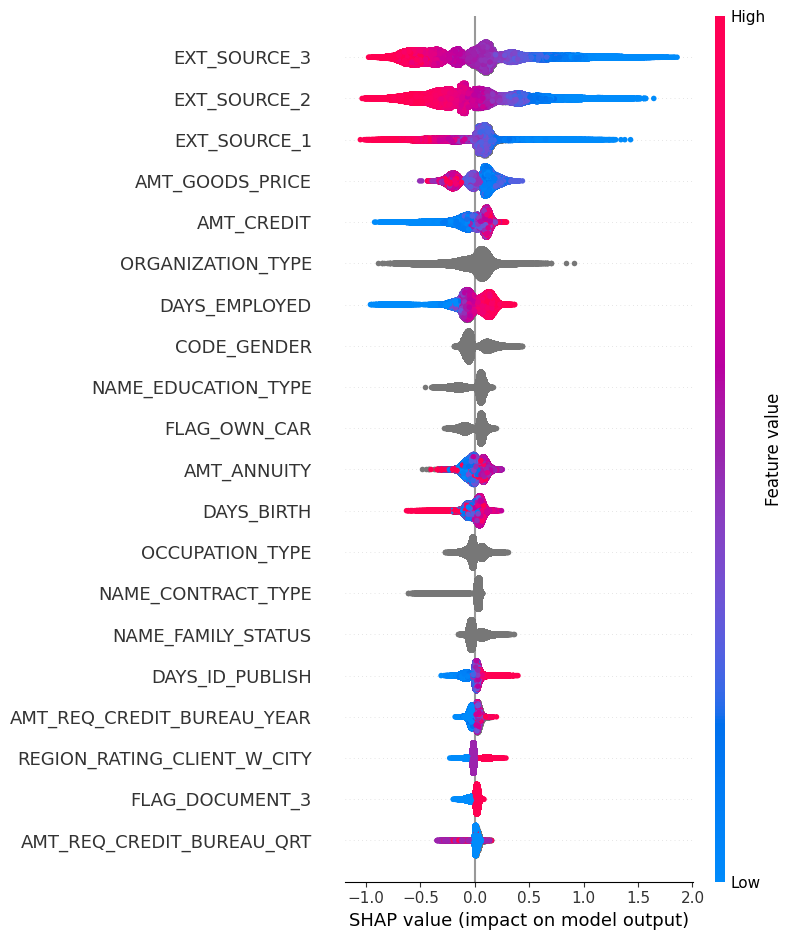

In [13]:
model_lgbm = LGBMClassifier(random_state=42, class_weight=class_weight_dict, objective='binary', metric='auc').fit(x_train, y_train)
explainer_lgbm   = shap.TreeExplainer(model_lgbm)
explanation_lgbm = explainer_lgbm(x_train, check_additivity=False)
shap_values_lgbm      = explanation_lgbm.values                        
mean_abs_shap_lgbm = np.abs(shap_values_lgbm).mean(axis=0)
print("\nSHAP summary plot for LightGBM:")
fig, ax = plt.subplots()
shap.summary_plot(
    shap_values_lgbm,               
    features=x_train,
    feature_names=x_train.columns.tolist(),
    max_display=20,             
    show=False
)
plt.show()

SHAP was not able to calculate all feature values, which is why some of the features are grey. The most important features are EXT_SOURCE_3, _2, and _1, which are the normalized external credit scores for each customer applying for Home Credit. For each of these variables, having higher scores increases the probability of getting a model output of zero (no defaulting). AMT_GOODS_PRICE is also an important variable, and having a higher AMT_GOODS_PRICE also decreases the probability of defaulting. The fourth most important feature was found to be AMT_CREDIT, where having a higher amount of credit on a loan increases the chance of defaulting. 



Extracting the top 70 features for testing a smaller model: 

In [ ]:
shap_importance_df = pd.DataFrame({
    "feature"          : x_train.columns,
    "mean_abs_shap"    : mean_abs_shap_lgbm,              
    "mean_signed_shap" : shap_values_lgbm.mean(axis=0)  
})
top_70_df = (
    shap_importance_df
      .loc[shap_importance_df["feature"] != "SK_ID_CURR"] 
      .sort_values("mean_abs_shap", ascending=False)
      .head(70)
      .reset_index(drop=True)
)
top_70_shap = top_70_df["feature"].tolist()
top_70_df.head()

,feature,mean_abs_shap,mean_signed_shap
0,EXT_SOURCE_3,0.384651,-0.001283
1,EXT_SOURCE_2,0.326014,-0.004525
2,EXT_SOURCE_1,0.174392,0.008000
3,AMT_GOODS_PRICE,0.137833,0.017243
4,AMT_CREDIT,0.114906,-0.022524


The top 70 shap features can now be tested on the model to see if this increases or decreases performance: 

In [15]:
features_shap_ordered = []
for c in x_train.columns: 
    if c in top_70_shap:
        features_shap_ordered.append(c)
x_shap = x_train[features_shap_ordered]
x_shap.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
181648,Cash loans,F,N,N,90000.0,227520.0,13189.5,180000.0,Unaccompanied,Commercial associate,...,0.0,1,0,0,0,0,0.0,0.0,1.0,1.0
229245,Cash loans,M,Y,Y,90000.0,161730.0,13095.0,135000.0,Unaccompanied,Commercial associate,...,-509.0,1,0,0,0,0,NaN,NaN,NaN,NaN
122525,Cash loans,M,N,Y,135000.0,728847.0,26307.0,553500.0,"Spouse, partner",Working,...,-1474.0,1,0,0,0,0,2.0,0.0,0.0,2.0
306311,Cash loans,M,N,N,135000.0,474183.0,34636.5,391500.0,Unaccompanied,Commercial associate,...,-2016.0,1,0,0,0,0,0.0,0.0,0.0,4.0
300658,Cash loans,F,N,Y,180000.0,254700.0,27558.0,225000.0,Unaccompanied,Commercial associate,...,-695.0,1,0,0,0,0,NaN,NaN,NaN,NaN


In [16]:
r_shap = get_results(models_1, x_shap, y_train, cv)

In [17]:
r_shap

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7544 ± 0.0015,0.2373 ± 0.0039,0.7126 ± 0.0021,0.8959 ± 0.0005,0.7126 ± 0.0021,0.7766 ± 0.0015,0.2199 ± 0.0027


This result is a little lower than the initial results.

## Permutation importance with hist-gb

Permutation importance can also be used with the top (hist-gb) model to compare top features with SHAP values: 

In [18]:
result = permutation_importance(model_lgbm, x_train, y_train, n_repeats=5, scoring='roc_auc', random_state=42)

In [19]:
importance_pi_histgb = pd.DataFrame({
    'feature': x_train.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

top_70_pi = importance_pi_histgb.head(70)['feature'].tolist()
if 'SK_ID_CURR' in top_70_pi:
    top_70_pi.remove('SK_ID_CURR')
importance_pi_histgb.head(10)

,feature,importance
41,EXT_SOURCE_3,0.068592
40,EXT_SOURCE_2,0.048258
38,ORGANIZATION_TYPE,0.027449
39,EXT_SOURCE_1,0.024737
8,AMT_GOODS_PRICE,0.019856
6,AMT_CREDIT,0.016823
7,AMT_ANNUITY,0.009284
15,DAYS_BIRTH,0.009265
16,DAYS_EMPLOYED,0.007488
1,CODE_GENDER,0.006274


Similarly to the SHAP feature importance, most important features are external credit ratings. Monetary amounts regarding the loan. (AMT_GOODS_PRICE, AMT_CREDIT, and AMT_ANNUITY) are also important features, as are some sociodemographic features (DAYS_EMPLOYED, DAYS_BIRTH). 

Trying a model with the selected 70 features: 

In [20]:
x_pi = []
for c in x_train.columns:
    if c in top_70_pi:
        x_pi.append(c)
x_pi = x_train[x_pi]

In [21]:
r_pi = get_results(models_1, x_pi, y_train, cv)
r_pi

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7541 ± 0.0020,0.2369 ± 0.0048,0.7130 ± 0.0014,0.8959 ± 0.0002,0.7130 ± 0.0014,0.7769 ± 0.0010,0.2200 ± 0.0015


This is essentially the same as the baseline (0.7545). 

## Trying smaller features set

In addition, the features selected for EDA examination in the previous notebook can be tested here: 


In [22]:
features_eda = ['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MODE',
 'FLOORSMAX_MEDI',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [23]:
x_eda = x_train[features_eda]

In [24]:
r_eda = get_results(models_1, x_eda, y_train, cv)
r_eda

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7527 ± 0.0017,0.2363 ± 0.0046,0.7109 ± 0.0017,0.8959 ± 0.0008,0.7109 ± 0.0017,0.7753 ± 0.0013,0.2194 ± 0.0042


This is also worse than the baseline (0.7545).

# Trying encoding missing values with target relationship

If the variables with missing values found in EDA to be correlated with the target variable are added to the dataset, then what happens? 

In [25]:
train_missing_indicator = x_train.copy()

In [26]:
missing_indicator_cols = ['NAME_TYPE_SUITE',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [27]:
for col in missing_indicator_cols:
    train_missing_indicator[col + '_missing'] = train_missing_indicator[col].isnull().astype(int)
train_missing_indicator

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,OBS_30_CNT_SOCIAL_CIRCLE_missing,DEF_30_CNT_SOCIAL_CIRCLE_missing,OBS_60_CNT_SOCIAL_CIRCLE_missing,DEF_60_CNT_SOCIAL_CIRCLE_missing,AMT_REQ_CREDIT_BUREAU_HOUR_missing,AMT_REQ_CREDIT_BUREAU_DAY_missing,AMT_REQ_CREDIT_BUREAU_WEEK_missing,AMT_REQ_CREDIT_BUREAU_MON_missing,AMT_REQ_CREDIT_BUREAU_QRT_missing,AMT_REQ_CREDIT_BUREAU_YEAR_missing
181648,Cash loans,F,N,N,2,90000.0,227520.0,13189.5,180000.0,Unaccompanied,...,0,0,0,0,0,0,0,0,0,0
229245,Cash loans,M,Y,Y,0,90000.0,161730.0,13095.0,135000.0,Unaccompanied,...,0,0,0,0,1,1,1,1,1,1
122525,Cash loans,M,N,Y,0,135000.0,728847.0,26307.0,553500.0,"Spouse, partner",...,0,0,0,0,0,0,0,0,0,0
306311,Cash loans,M,N,N,0,135000.0,474183.0,34636.5,391500.0,Unaccompanied,...,0,0,0,0,0,0,0,0,0,0
300658,Cash loans,F,N,Y,0,180000.0,254700.0,27558.0,225000.0,Unaccompanied,...,0,0,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31304,Revolving loans,F,N,Y,1,135000.0,405000.0,20250.0,405000.0,Unaccompanied,...,0,0,0,0,1,1,1,1,1,1
121193,Cash loans,F,N,N,0,157500.0,272520.0,21528.0,225000.0,Unaccompanied,...,0,0,0,0,0,0,0,0,0,0
248504,Cash loans,F,N,N,0,90000.0,246357.0,24493.5,234000.0,Unaccompanied,...,0,0,0,0,0,0,0,0,0,0
175469,Cash loans,F,N,Y,0,112500.0,810000.0,26901.0,810000.0,Children,...,0,0,0,0,0,0,0,0,0,0


In [28]:
r_missing_indicator = get_results(models_1, train_missing_indicator, y_train, cv)
r_missing_indicator

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7545 ± 0.0014,0.2368 ± 0.0049,0.7131 ± 0.0017,0.8961 ± 0.0005,0.7131 ± 0.0017,0.7769 ± 0.0013,0.2210 ± 0.0027


Adding in the indicator columns does not have an effect on the model's auc. 

# Trying imputation for numerical variables with median

In [29]:
x_train_impute_median = x_train.copy()

In [30]:
x_train_impute_median.fillna(x_train_impute_median.median(numeric_only=True), inplace=True)

In [31]:
r_impute_median = get_results(models_1, x_train_impute_median, y_train, cv)
r_impute_median


,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7537 ± 0.0015,0.2376 ± 0.0043,0.7114 ± 0.0015,0.8962 ± 0.0006,0.7114 ± 0.0015,0.7757 ± 0.0011,0.2209 ± 0.0032


Imputing missing numerical values with the median values decreases AUC slightly (0.7545 from 0.7537). How about trying the same thing with mean imputation? 

# Impute missing numerical values with mean

In [32]:
x_train_impute_mean = x_train.copy()
x_train_impute_mean.fillna(x_train_impute_mean.mean(numeric_only=True), inplace=True)

In [33]:
r_impute_mean = get_results(models_1, x_train_impute_mean, y_train, cv)
r_impute_mean

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7536 ± 0.0009,0.2366 ± 0.0040,0.7112 ± 0.0017,0.8959 ± 0.0004,0.7112 ± 0.0017,0.7756 ± 0.0012,0.2196 ± 0.0017


The performance is worse with mean imputation as compared with median imputation.

# Outlier treatment and processing

Many of the numerical columns had outliers and were skewed heavily to the right. Capping could change model performance: 

## Trying to cap skewed columns at the 99th percentile: 

In [34]:
x_cap = x_train.copy()

In [35]:
columns_to_cap = get_columns_with_outliers(x_cap, threshold=0.01)

In [36]:
columns_to_cap

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPART

These seem to be columns that were indeed skewed and identified during EDA. 

In [37]:
capped_train = cap_outliers(x_cap, columns_to_cap, 0.001, 0.999)

In [38]:
r_cap = get_results(models_1, capped_train, y_train, cv)
r_cap

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7544 ± 0.0015,0.2369 ± 0.0047,0.7125 ± 0.0018,0.8960 ± 0.0004,0.7125 ± 0.0018,0.7765 ± 0.0013,0.2204 ± 0.0022


No change is noticed here as compared to the baseline model. This is logical, as gradient boosted models bin values already.

## Log transform of skewed columns: 

Taking the log of these skewed columns could change the model's performance: 

In [39]:
x_log = x_train.copy()

In [40]:
columns_for_log = suggest_log_transform_columns(x_log)
columns_for_log

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'OWN_CAR_AGE',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

These columns also correspond to right-skewed columns identified in the EDA section. 

In [41]:
log_train = log_transform_column(x_log, columns_for_log)

Plotting the original and log-transformed distributions: 

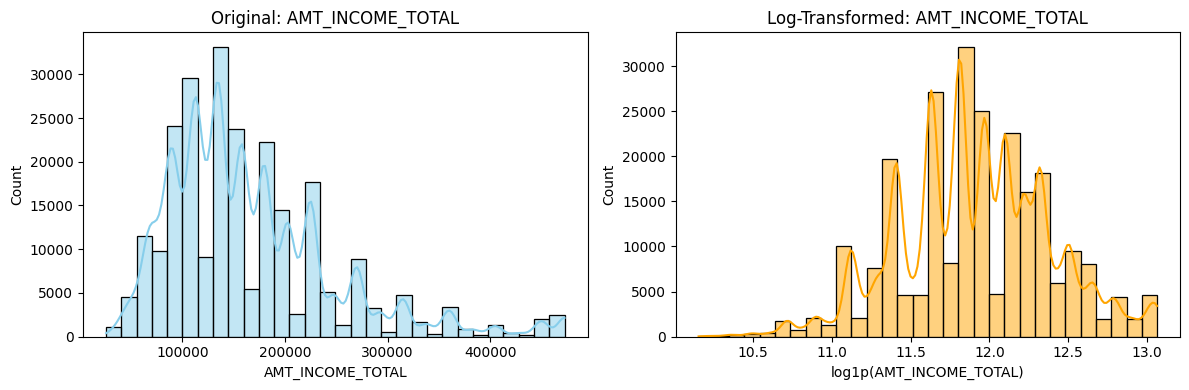

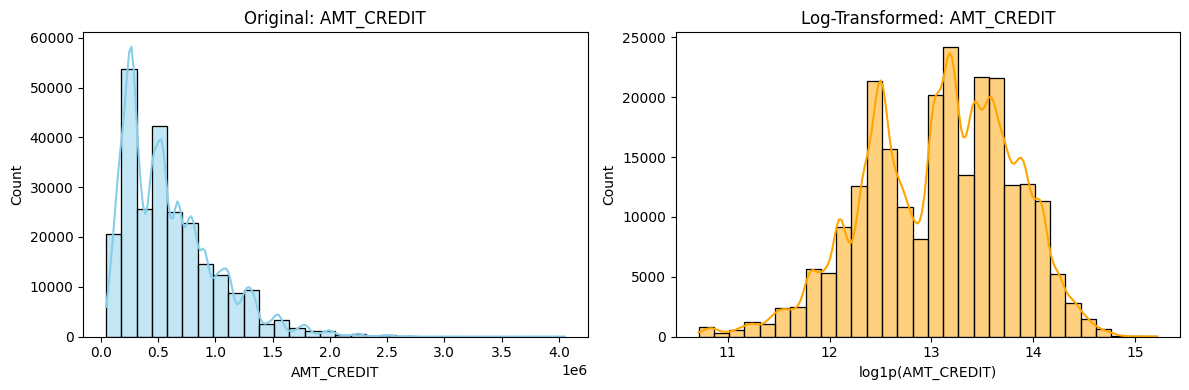

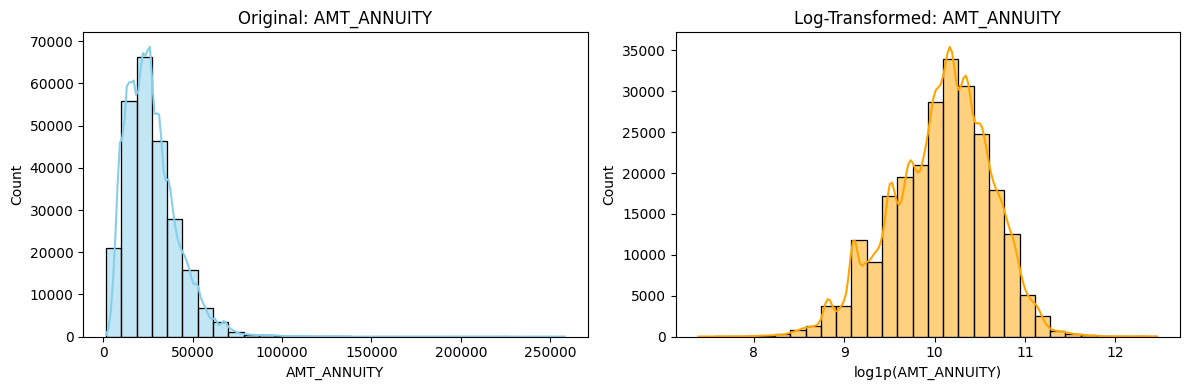

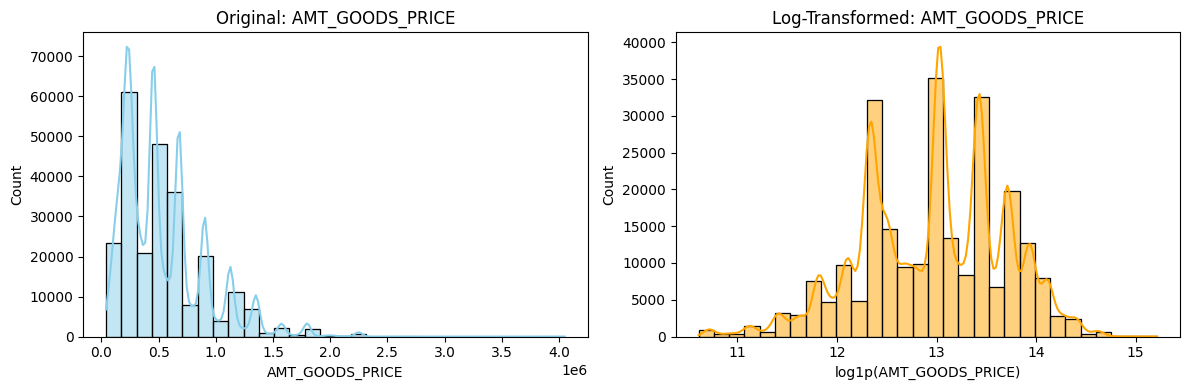

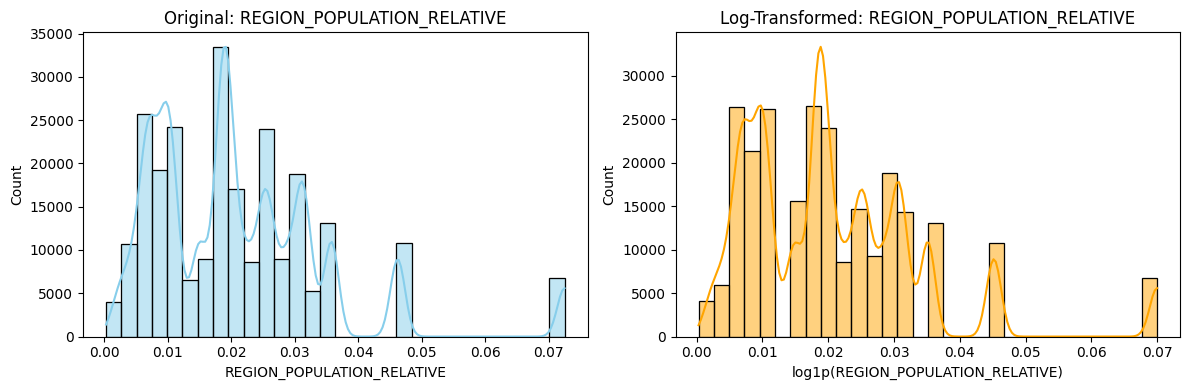

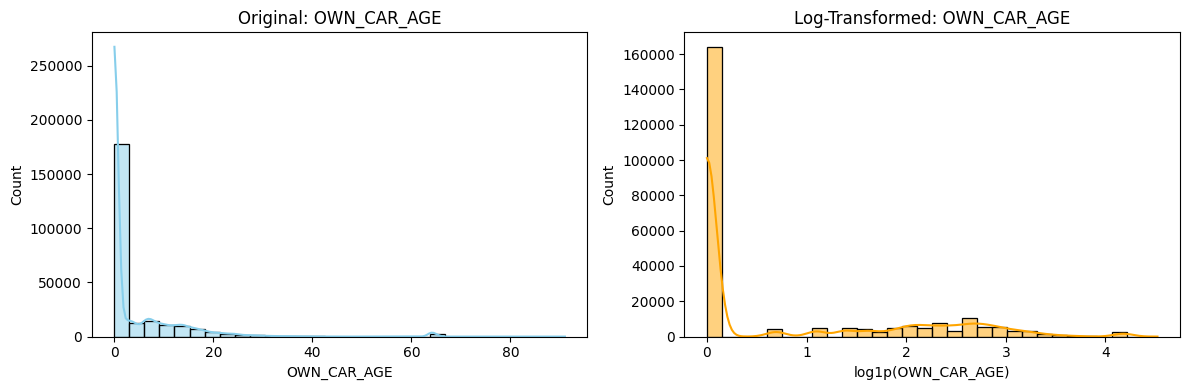

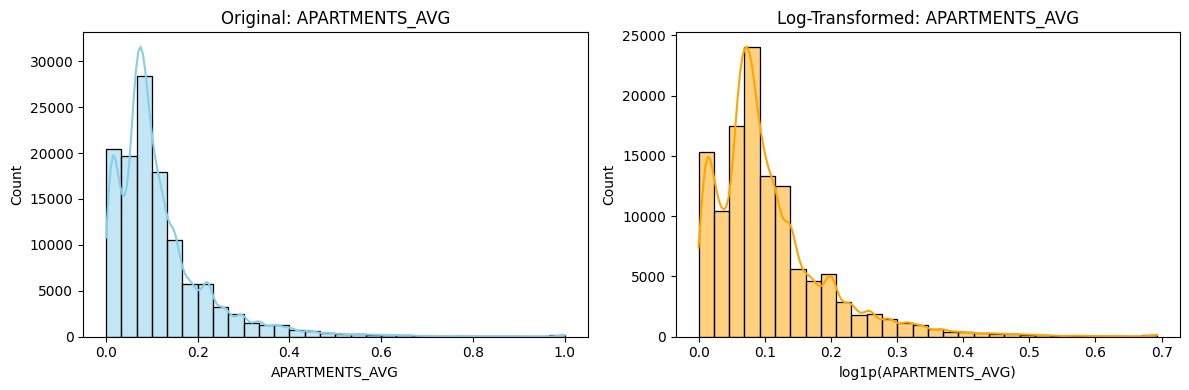

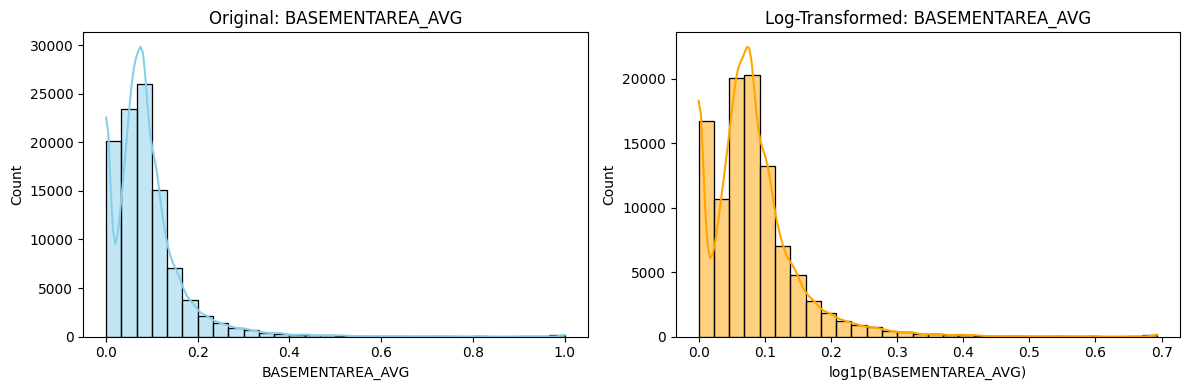

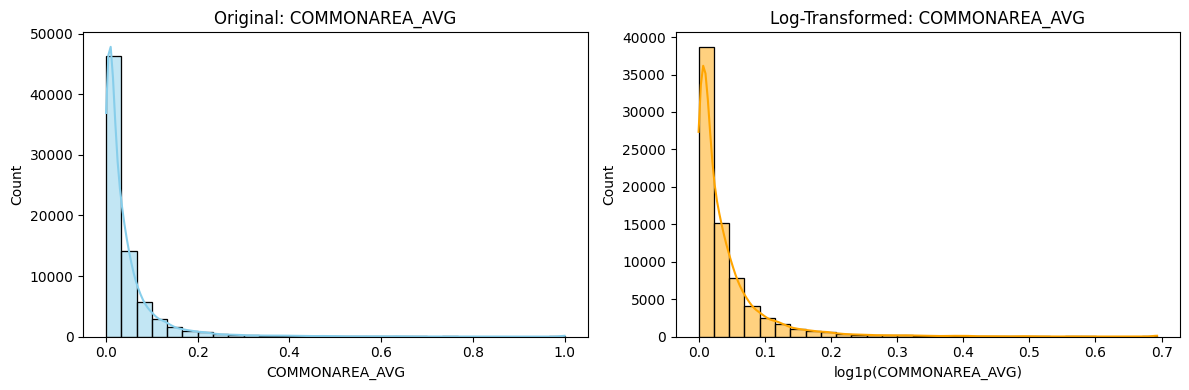

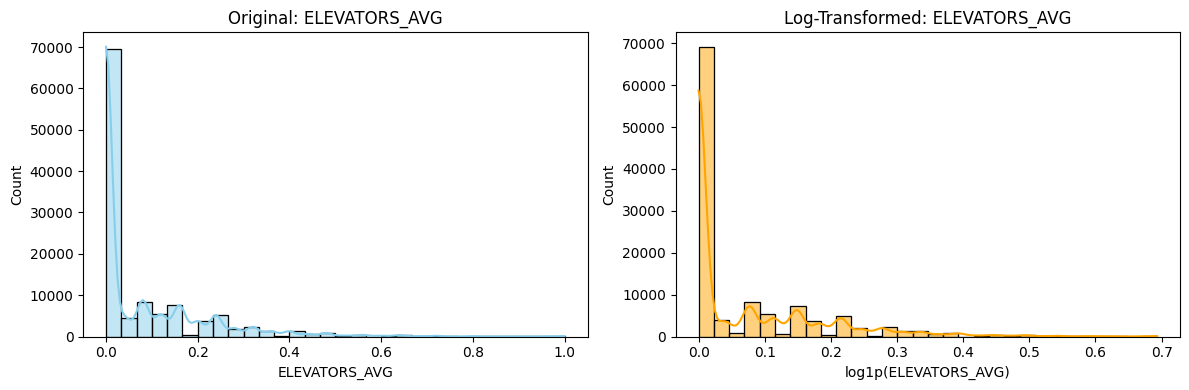

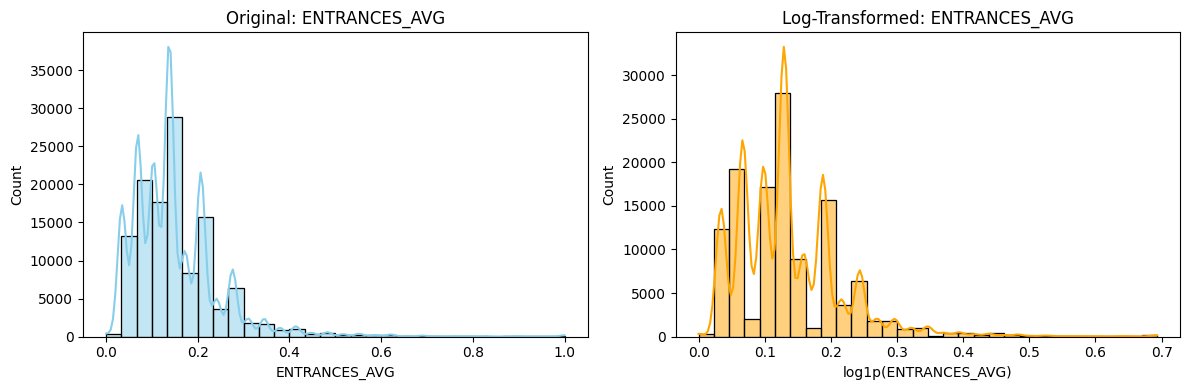

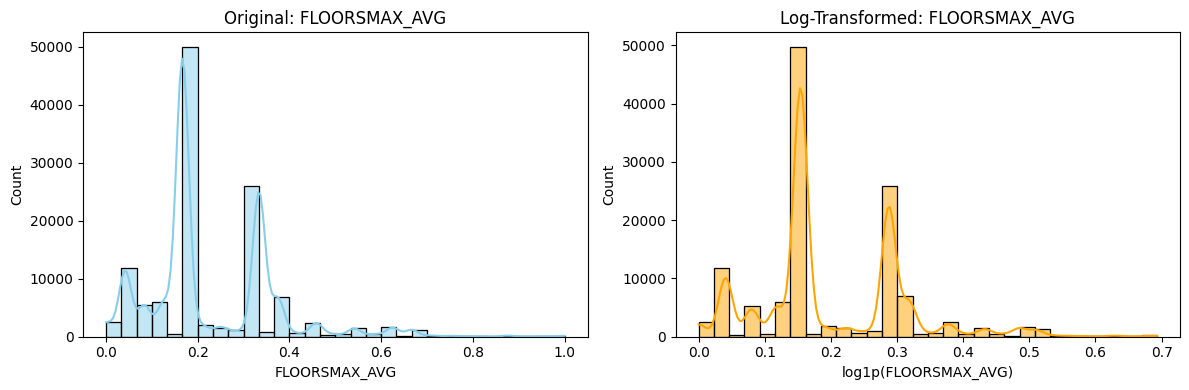

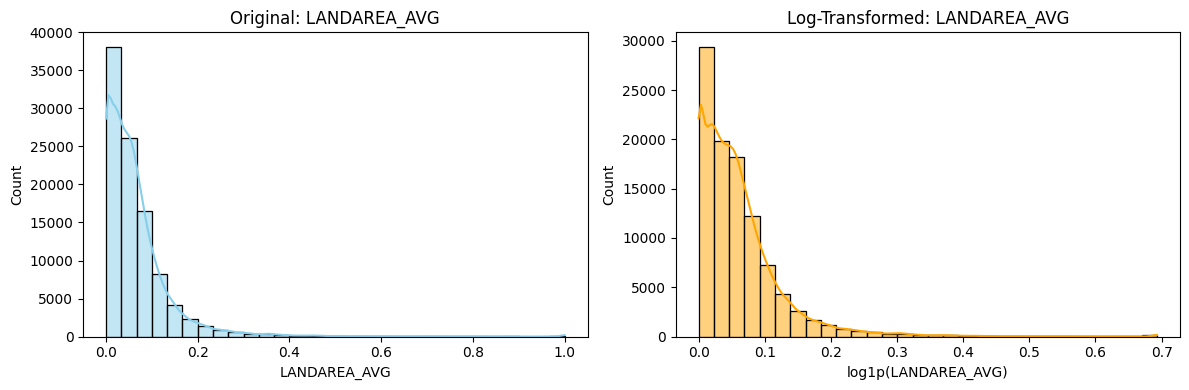

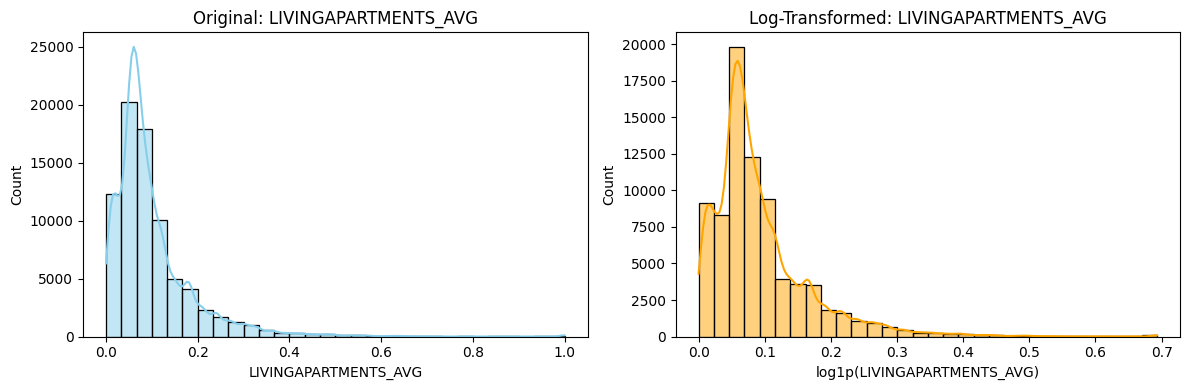

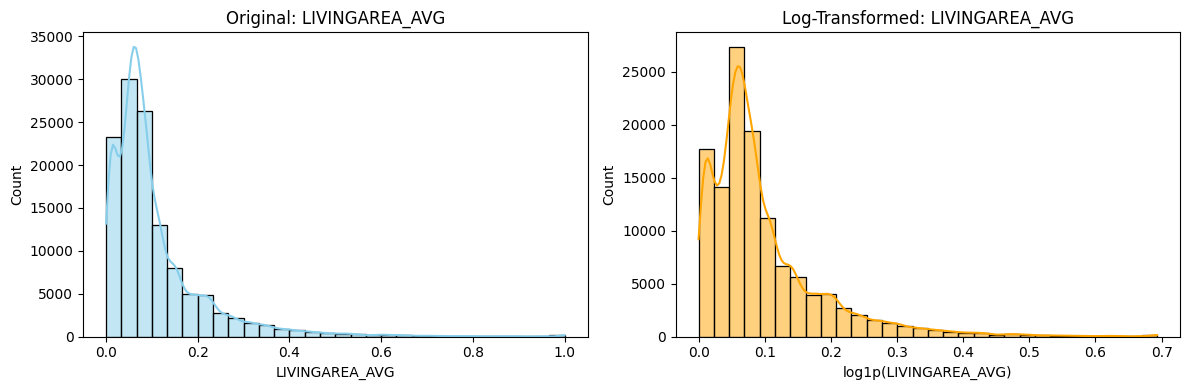

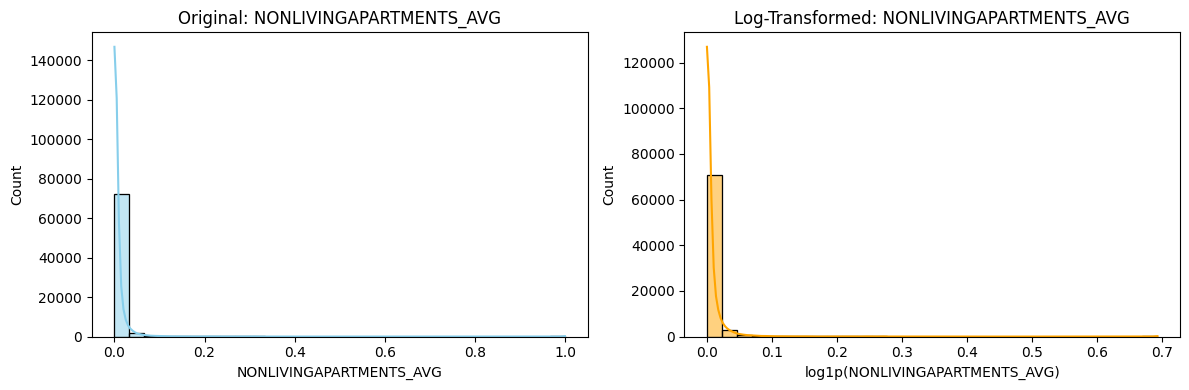

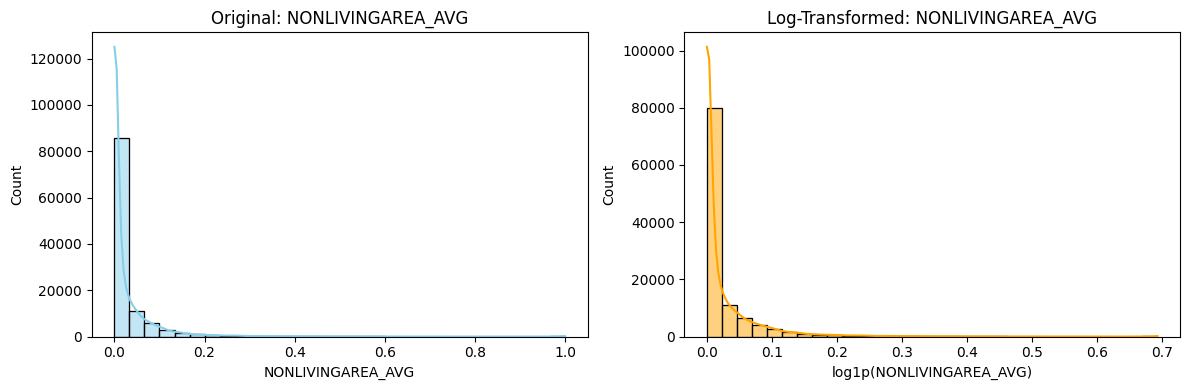

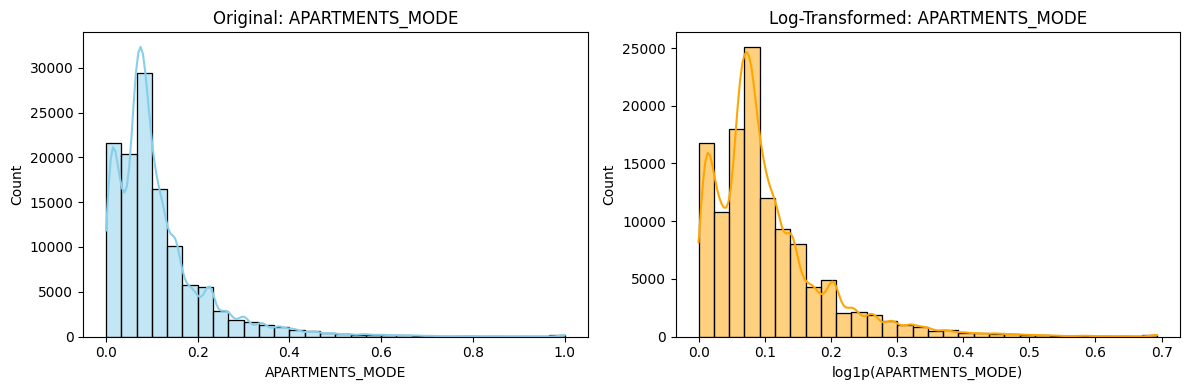

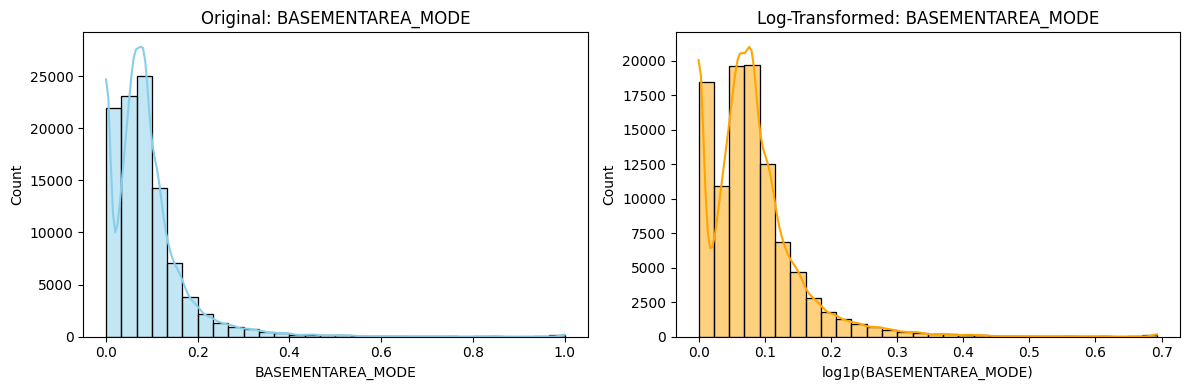

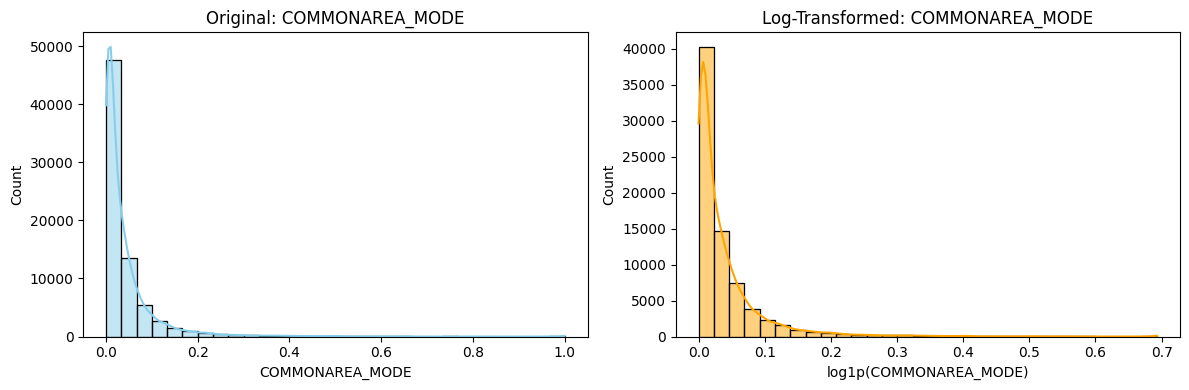

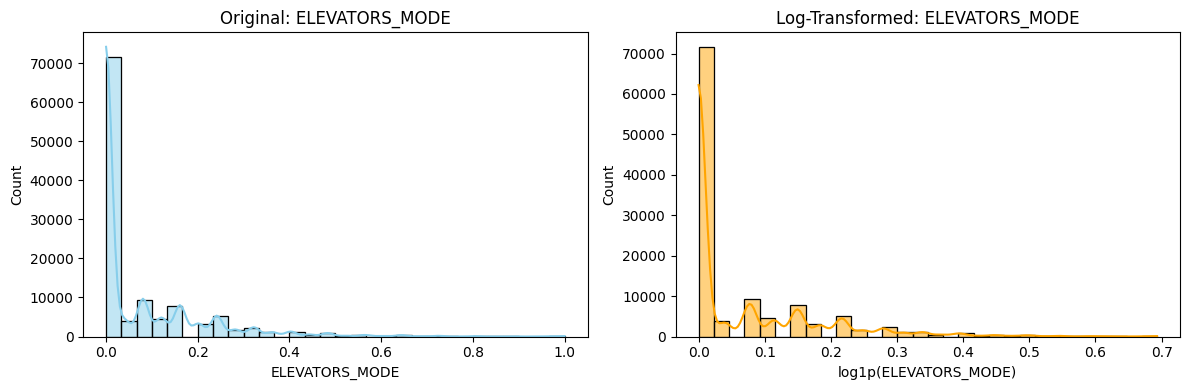

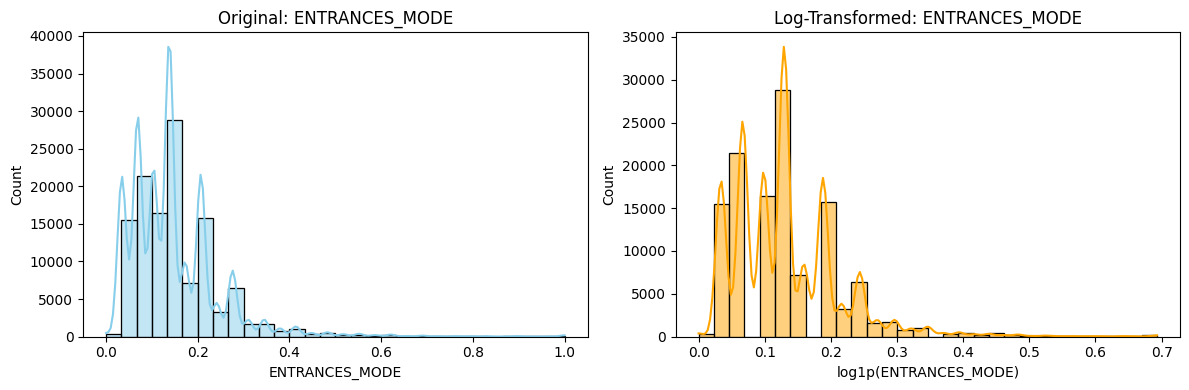

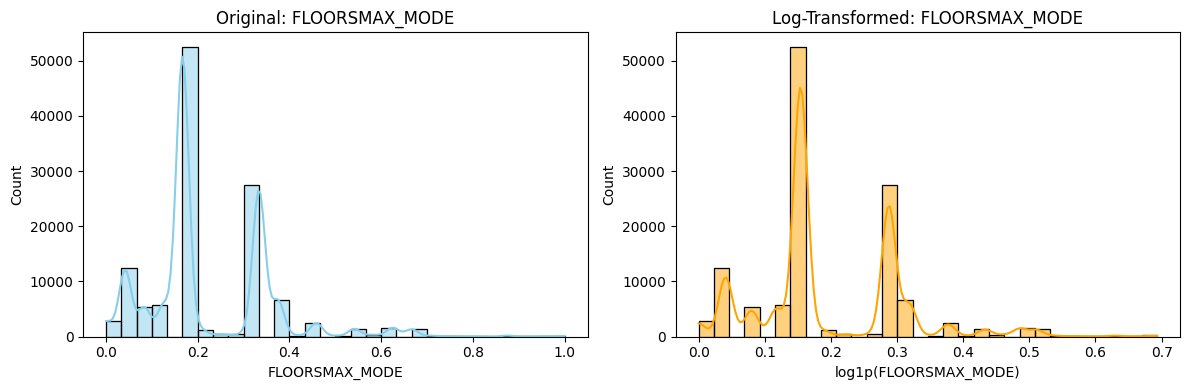

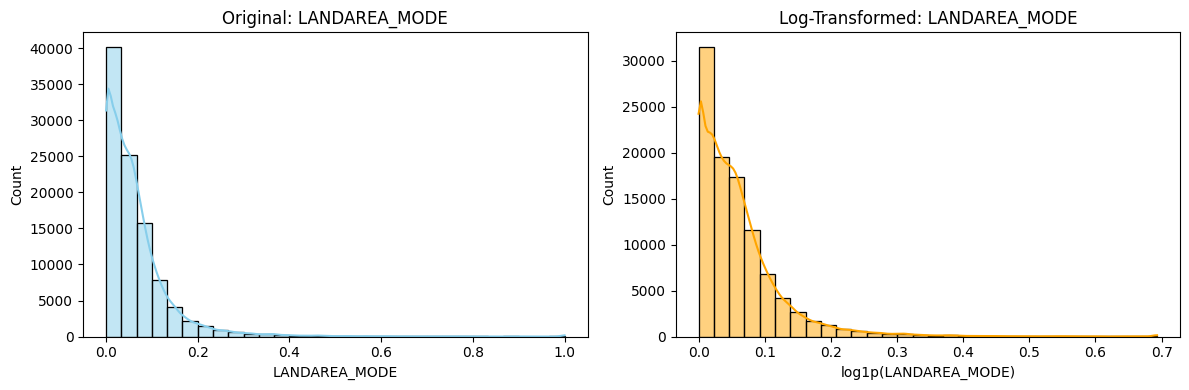

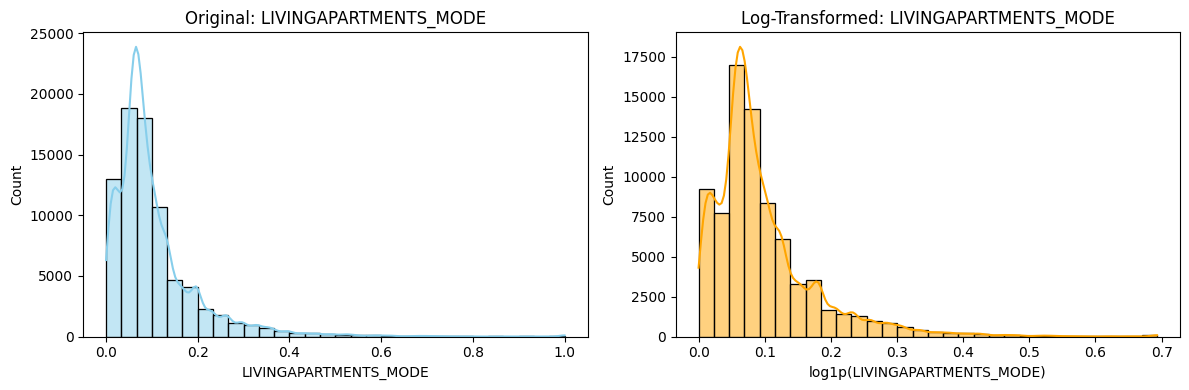

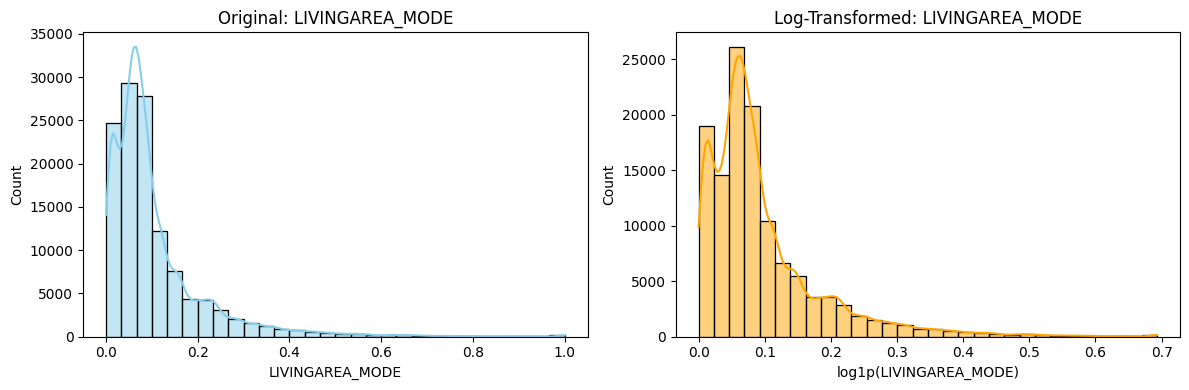

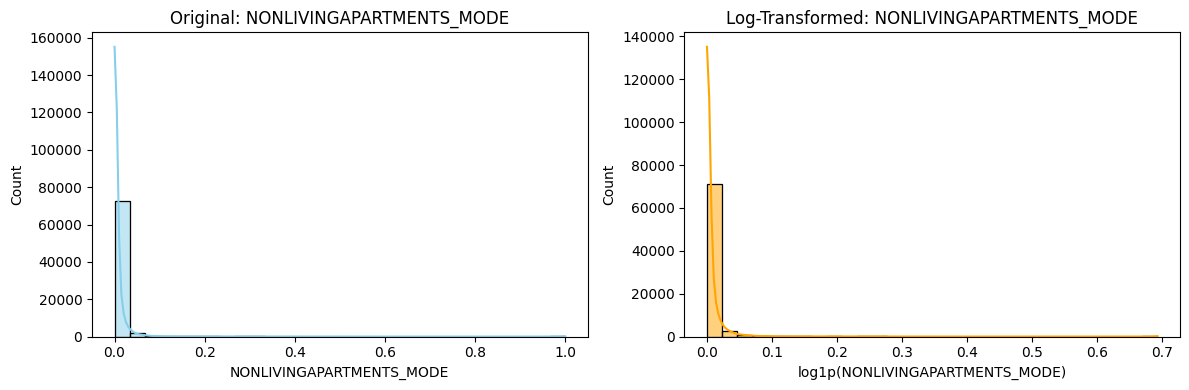

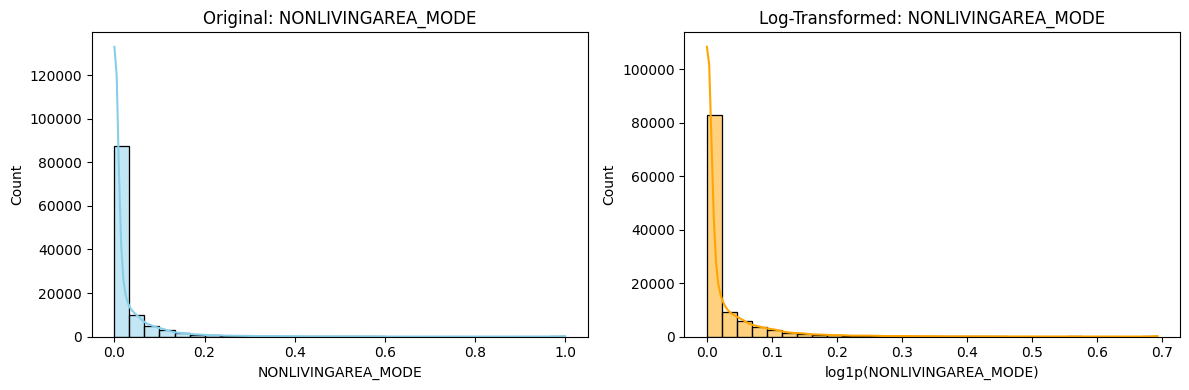

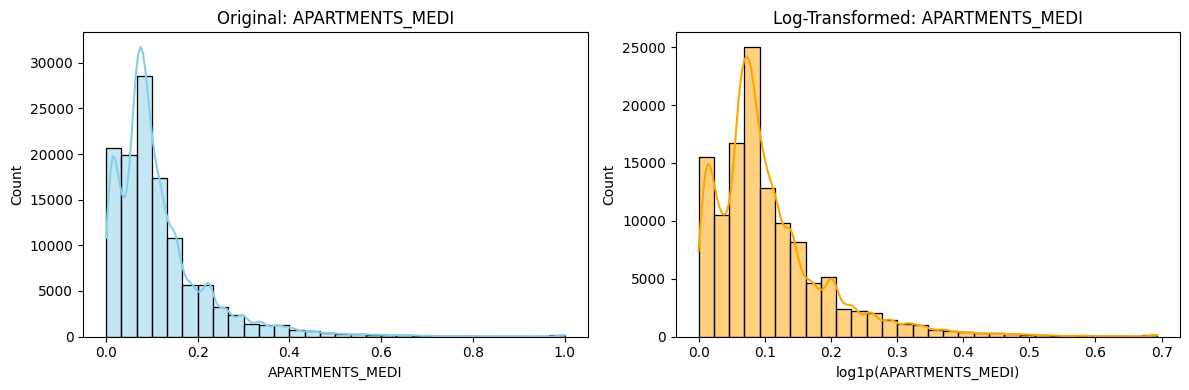

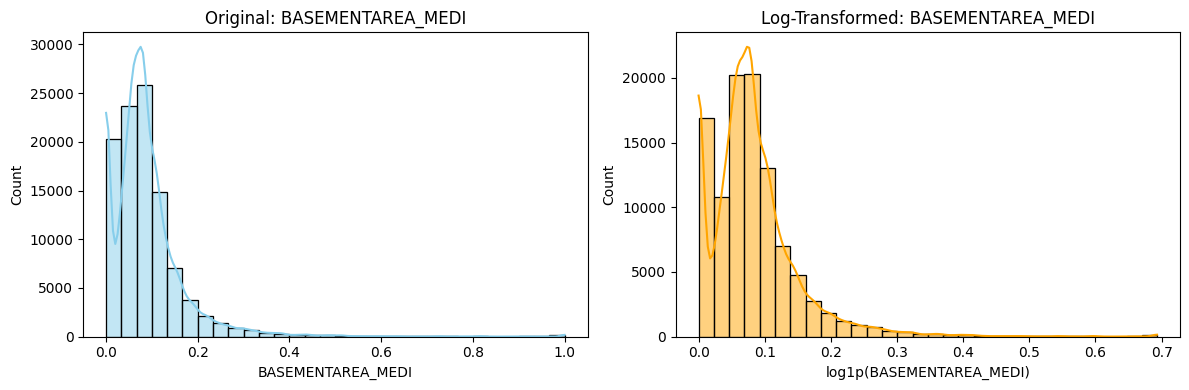

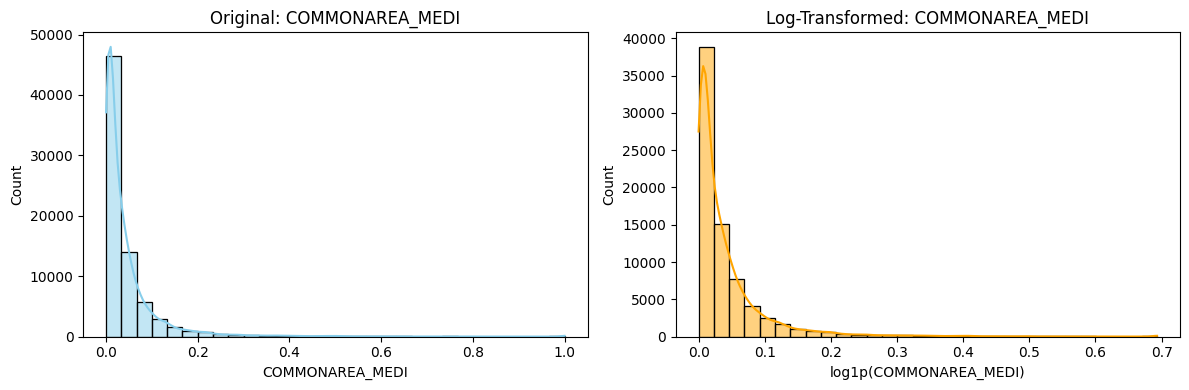

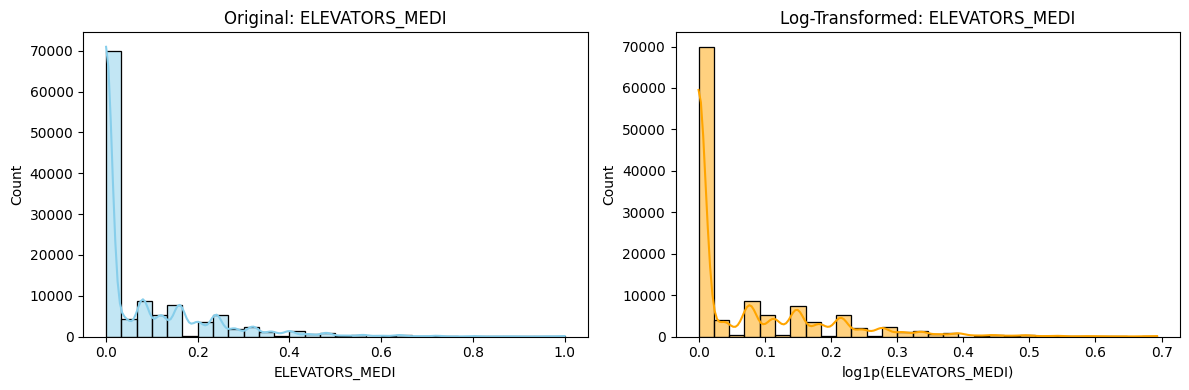

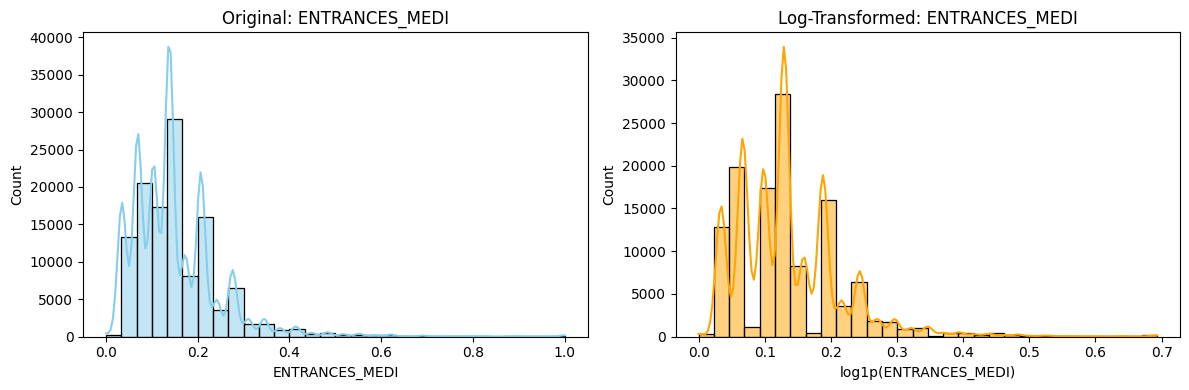

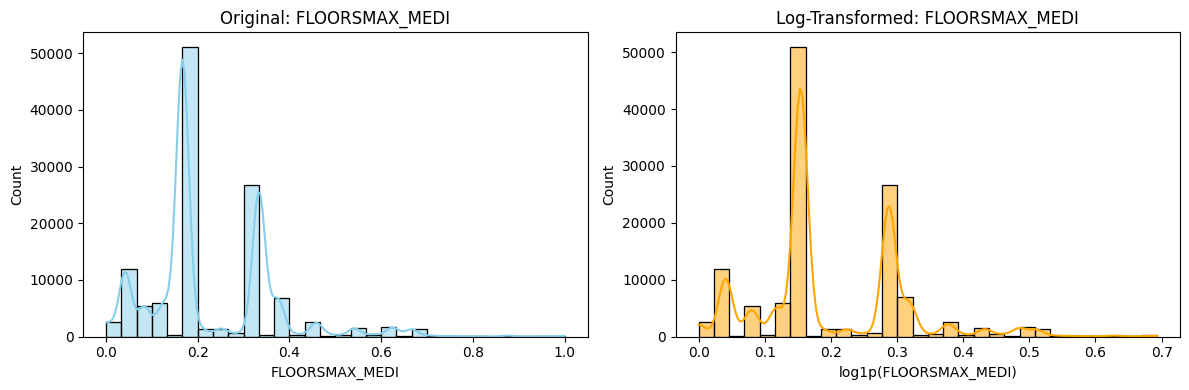

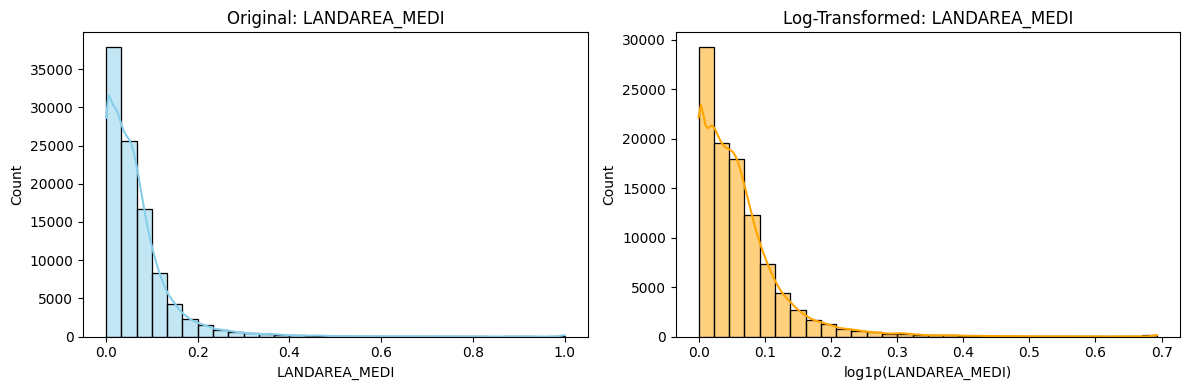

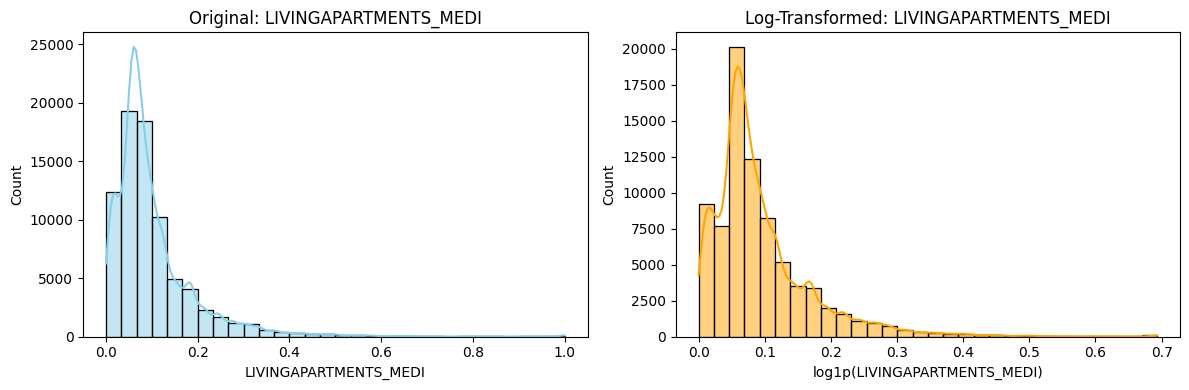

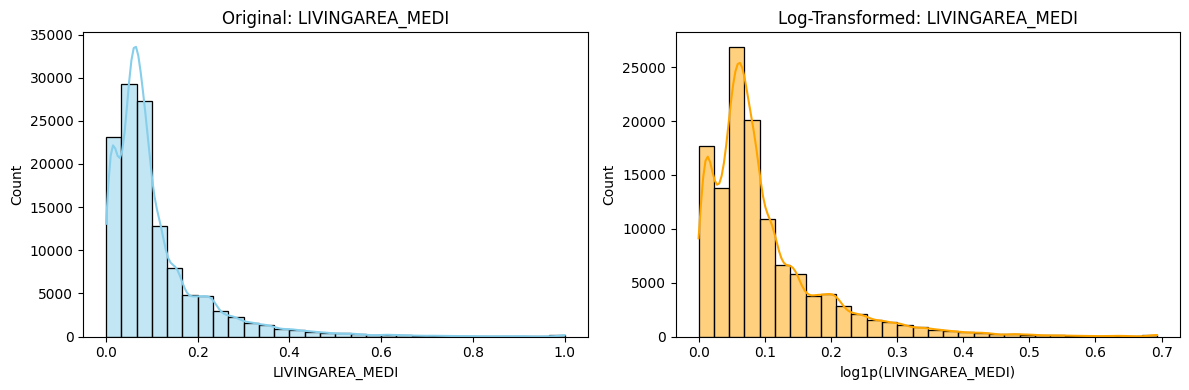

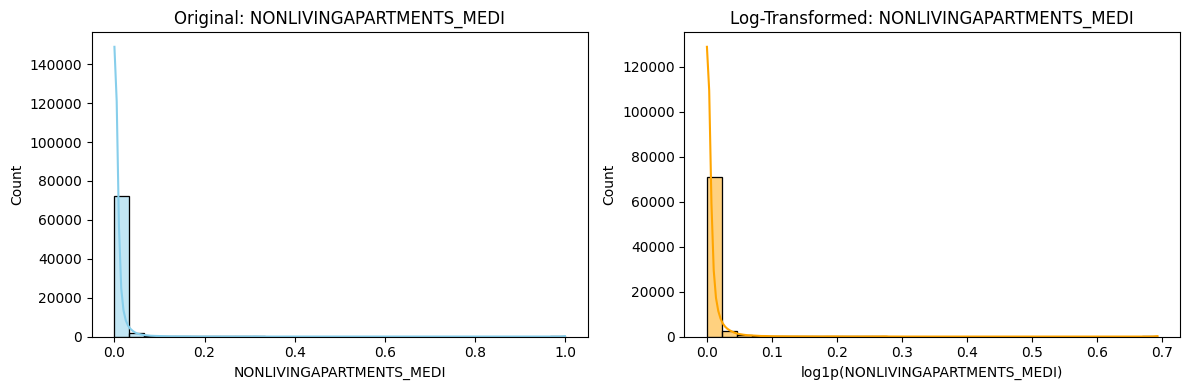

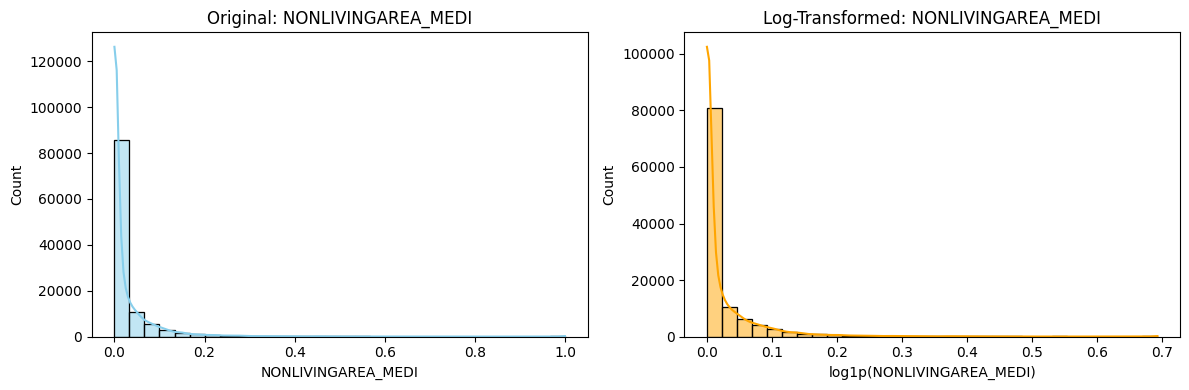

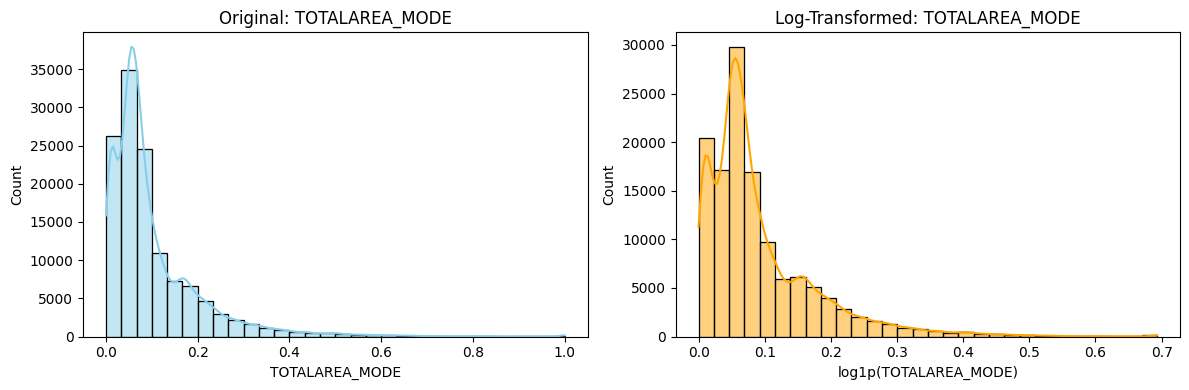

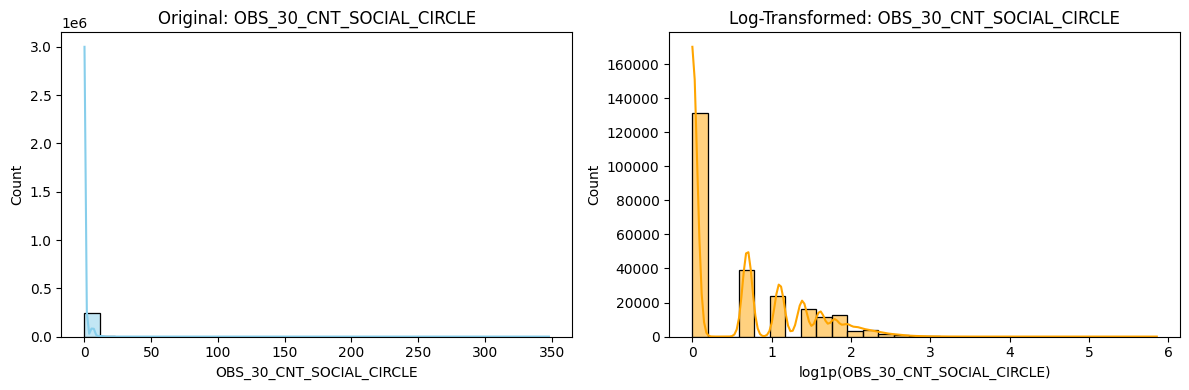

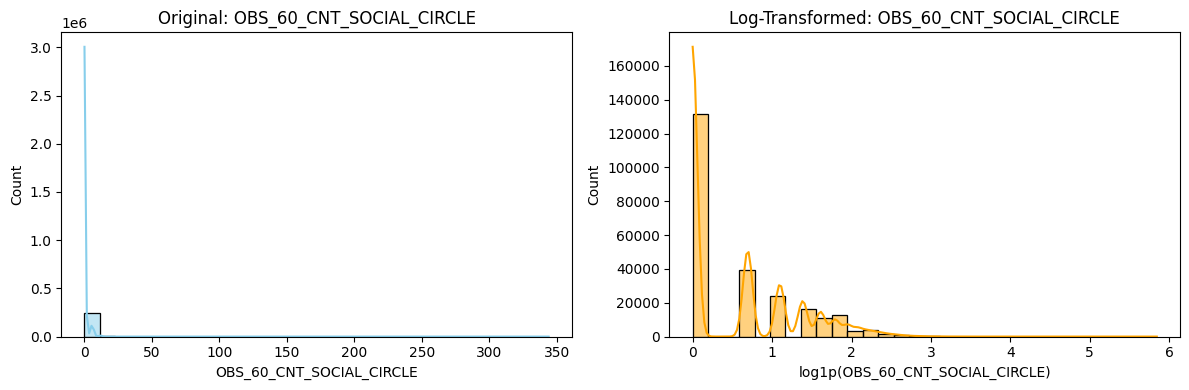

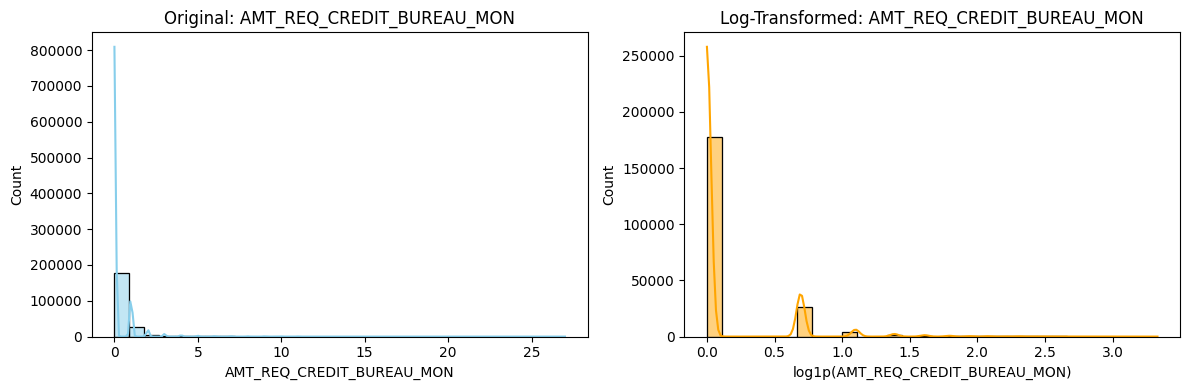

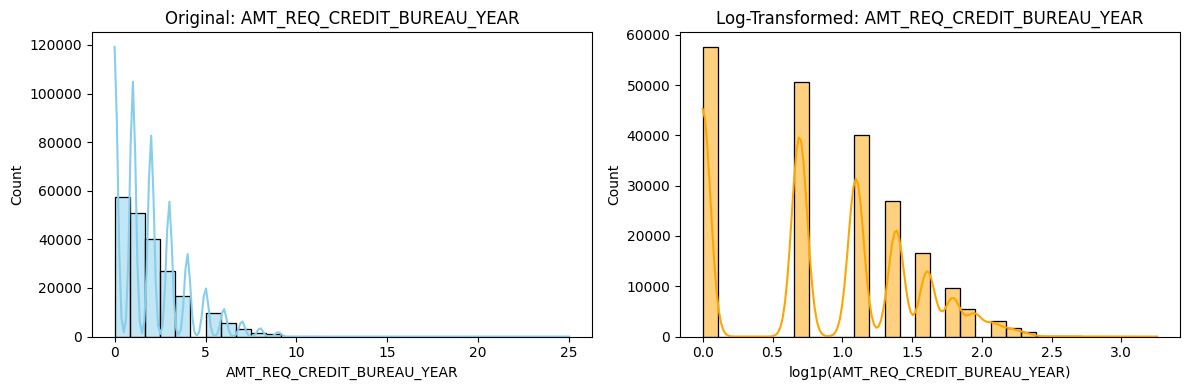

In [42]:
plot_log_transformed_distributions(log_train, columns_for_log)


In [43]:
r_log = get_results(models_1, log_train, y_train, cv)
r_log

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7540 ± 0.0016,0.2375 ± 0.0042,0.7165 ± 0.0022,0.8956 ± 0.0006,0.7165 ± 0.0022,0.7794 ± 0.0017,0.2201 ± 0.0037


This also did not change model performance.

# Binning cnt_* variables

CNT_FAM_MEMBERS and CNT_CHILDREN could be binned, as most people have less than 4 family members or children. First, both variables are binned, then only cnt_fam_members is binned: 

In [44]:
x_binned = x_train.copy()

In [45]:
x_binned['CNT_FAM_MEMBERS_BIN'] = pd.cut(x_binned['CNT_FAM_MEMBERS'], bins=[0, 1, 2, 3, 4, x_binned['CNT_FAM_MEMBERS'].max()], labels=False)
x_binned['CNT_FAM_MEMBERS_BIN'] = x_binned['CNT_FAM_MEMBERS_BIN'].astype('category')

x_binned = x_binned.drop(['CNT_FAM_MEMBERS'], axis=1)

In [46]:
r_binned = get_results(models_1, x_binned, y_train, cv)
r_binned

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7544 ± 0.0016,0.2367 ± 0.0045,0.7133 ± 0.0023,0.8961 ± 0.0005,0.7133 ± 0.0023,0.7771 ± 0.0017,0.2213 ± 0.0032


With both cnt_fam_members and cnt_children binned, the model performance is a little worse as in the original model (0.754 for auc). With only cnt_fam_members binned, a value of 0.7544 for auc is obtained, which is almost the same as the baseline model. 

# Grouping categorical variables: 

Some categorical variables had many categories and could benefit from being grouped together: 

In [47]:
x_grouped = x_train.copy()

In [48]:
group_map = {
    'Accountants': 'Accountants',
    'Cleaning staff': 'Service',
    'Cooking staff': 'Service',
    'Core staff': 'Core staff',
    'Drivers': 'Drivers', 
    'HR staff': 'Other',
    'High skill tech staff': 'Tech',
    'IT staff': 'Tech',
    'Laborers': 'Laborers', 
    'Low-skil Laborers': 'Laborers',
    'Managers': 'Managers',
    'Medicine staff': 'Medicine',
    'Private service staff': 'Other',
    'Realty agents': 'Other',
    'Sales staff': 'Sales',
    'Secretaries': 'Other',
    'Security staff': 'Other', 
    'Waiters/barmen staff': 'Service'

    
}
    
x_grouped['OCCUPATION_TYPE_GROUPED'] = x_grouped['OCCUPATION_TYPE'].map(group_map)


In [49]:
group_map = {
    'Businessman': 'Other',
    'Commercial associate': 'Commercial associate',
    'Pensioner': 'Pensioner',
    'State servant': 'State servant',
    'Student': 'Other', 
    'Unemployed': 'Other',
    'Working': 'Working',
}
    
x_grouped['NAME_INCOME_TYPE_GROUPED'] = x_grouped['NAME_INCOME_TYPE'].map(group_map)

In [50]:
group_map = {
    'Business Entity Type 3': 'Business',
    'Business Entity Type 2': 'Business',
    'Business Entity Type 1 ': 'Business',

    'XNA': 'Unknown', 
    'Self-employed': 'Self-employed',         
    'Other': 'Other',                  
    'Medicine': 'Public Sector',                
    'Government': 'Public Sector',                
    'School': 'Public Sector',  
    'Kindergarten': 'Public Sector',
    'Security Ministries': 'Public Sector',                  
    'Housing': 'Public Sector',
    'Military': 'Public Sector',
    'Police': 'Public Sector',
    'Postal': 'Public Sector',
    'Security Ministries': 'Public Sector',
    'University': 'Public Sector',
    'Emergency': 'Public Sector',

    'Trade: type 7': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 5': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 2': 'Trade', 
    'Trade: type 1': 'Trade', 
    'Electricity ': 'Trade',        
    'Construction': 'Trade',              
  
    'Transport: type 4': 'Transport',
    'Transport: type 3': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 1': 'Transport',
    'Industry: type 13': 'Industry',
    'Industry: type 12 ': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 8': 'Industry',
    'Industry: type 7': 'Industry', 
    'Industry: type 6': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 4 ': 'Industry',       
    'Industry: type 3': 'Industry', 
    'Industry: type 2 ': 'Industry',
    'Industry: type 1 ': 'Industry',      
    'Industry: type 11': 'Industry', 
    'Agriculture': 'Industry', 

    'Services ': 'Service',  
    'Hotel': 'Service',
    'Restaurant': 'Service',
    'Cleaning': 'Service',
    'Realtor': 'Service',
    'Legal Services': 'Service',
    'Advertising': 'Other',   
    'Religion': 'Other',
    'Culture': 'Other',
    'Bank': 'Finance',
    'Insurance': 'Finance',
    'Telecom': 'Other',
    'Mobile': 'Other'
}
    
x_grouped['ORGANIZATION_TYPE_GROUPED'] = x_grouped['ORGANIZATION_TYPE'].map(group_map)


In [51]:
group_map = {
    'House / apartment': 'House / apartment',
    'Municipal apartment': 'Other apartment',
    'Office apartment': 'Other apartment',
    'Rented apartment': 'Other apartment',
    'With parents': 'With parents',
    'Co-op apartment': 'Other apartment',
}
    
x_grouped['NAME_HOUSING_TYPE_GROUPED'] = x_grouped['NAME_HOUSING_TYPE'].map(group_map)

In [52]:
x_grouped = x_grouped.drop(columns=['OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'ORGANIZATION_TYPE', 'NAME_HOUSING_TYPE'])

In [53]:
cat_features_grouped = x_grouped.select_dtypes(include='object').columns.tolist()
cat_features_grouped_index = [x_grouped.columns.get_loc(col) for col in cat_features_grouped]
for col in cat_features_grouped: 
    x_grouped[col] = x_grouped[col].fillna('missing') 
    x_grouped[col] = x_grouped[col].astype('category')

In [54]:
r_grouped = get_results(models_1, x_grouped, y_train, cv)
r_grouped

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7557 ± 0.0020,0.2389 ± 0.0047,0.7082 ± 0.0021,0.8964 ± 0.0006,0.7082 ± 0.0021,0.7734 ± 0.0016,0.2206 ± 0.0035


Grouping these columns increased the area under the ROC curve by about 0.002. 

# Changing days to years: 

All columns measuring a time could be changed to years instead of days to increase explainability: 

In [55]:
x_years = x_train.copy()

In [56]:
x_years['AGE'] = x_years['DAYS_BIRTH'] / -365
x_years['DAYS_EMPLOYED'] = x_years['DAYS_EMPLOYED'].replace(365243, np.nan)
x_years['YEARS_EMPLOYED'] = x_years['DAYS_EMPLOYED'] / -365
x_years['YEARS_LAST_PHONE_CHANGE'] = x_years['DAYS_LAST_PHONE_CHANGE'] / -365
x_years['YEARS_REGISTRATION'] = x_years['DAYS_REGISTRATION'] / -365
x_years['YEARS_ID_PUBLISH'] = x_years['DAYS_ID_PUBLISH'] / -365
x_years.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'], axis=1, inplace=True)

In [57]:
r_days_to_years = get_results(models_1, x_years, y_train, cv)
r_days_to_years

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7536 ± 0.0017,0.2371 ± 0.0049,0.7131 ± 0.0021,0.8959 ± 0.0008,0.7131 ± 0.0021,0.7770 ± 0.0016,0.2201 ± 0.0041


This is a slight decrease to the AUC score. 

# Drop features with missing values that account for a certain percentage: 

In [58]:
x_missing_drop = x_train.copy()

Getting a dataframe with missing value information: 

In [59]:
missing, no_missing = get_missing_df_info(x_missing_drop)

Empty strings: (array([], dtype=int64), array([], dtype=int64))
XNA strings: (array([], dtype=int64), array([], dtype=int64))
Percentage of total rows with missing values: 90.83688335338688


Looking at the columns missing over 65% of their data: 

In [60]:
cols_missing_over_65 = missing[missing['Missing percentage'] > 65].index.to_list()

Looking at these columns, dropping them, and looking at model results: 

In [61]:
cols_missing_over_65

['COMMONAREA_MODE',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MODE',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_AVG',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_MODE']

In [62]:
x_missing_drop = x_missing_drop.drop(cols_missing_over_65, axis=1)

In [63]:
r_drop_missing_cols = get_results(models_1, x_missing_drop, y_train, cv)
r_drop_missing_cols

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7539 ± 0.0017,0.2361 ± 0.0046,0.7126 ± 0.0012,0.8957 ± 0.0006,0.7126 ± 0.0012,0.7766 ± 0.0009,0.2190 ± 0.0031


Removing columns missing over 65% of their values decreases the AUC slightly. 

# Encoding categorical variables: 

One hot encoding categorical variables could affect model's performance. 

In [64]:
x_encoded = x_train.copy()

Selecting the features to one hot encode: 

In [65]:
cat_features = x_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
cat_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

One hot encoding categorical variables: 

In [66]:
x_encoded = pd.get_dummies(x_encoded, columns=cat_features, drop_first=False)
x_encoded.columns = x_encoded.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)


Evaluating the model: 

In [67]:
r_encoded = get_results(models_1, x_encoded, y_train, cv)
r_encoded

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7560 ± 0.0018,0.2392 ± 0.0045,0.7069 ± 0.0026,0.8965 ± 0.0006,0.7069 ± 0.0026,0.7725 ± 0.0019,0.2202 ± 0.0034


This is also a slight improvement over the baseline by about 0.002

# Feature Engineering: 

Often, boosted models improve when feature ratios or other interactions are added. A variety of new features are added here and tested to see if auc is improved. Each time a new feature is added, it is tested and the result is shown in a table (below). Only features that improve the model's auc are kept. When division between features occurs, any zeros in the denominator are replaced by unknown values, and the corresponding result is replaced by zero so as to handle zero division errors.

In [68]:
x_new_features = x_train.copy()

Features that did improve auc: 

In [ ]:
x_new_features['credit_annuity_ratio'] = (x_new_features['AMT_CREDIT'] / x_new_features['AMT_ANNUITY'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
x_new_features['age_score_ratio'] = (x_new_features['DAYS_BIRTH'] / x_new_features['EXT_SOURCE_1'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
x_new_features['score_credit_ratio'] = (x_new_features['EXT_SOURCE_2'] / x_new_features['AMT_CREDIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
x_new_features['income_goods_ratio'] = (x_new_features['AMT_INCOME_TOTAL'] / x_new_features['AMT_GOODS_PRICE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
x_new_features['SUM_FLAG_DOCUMENT'] = x_new_features['FLAG_DOCUMENT_2'] + x_new_features['FLAG_DOCUMENT_3'] + x_new_features['FLAG_DOCUMENT_4'] + x_new_features['FLAG_DOCUMENT_5'] + x_new_features['FLAG_DOCUMENT_6'] + x_new_features['FLAG_DOCUMENT_7'] + x_new_features['FLAG_DOCUMENT_8'] + x_new_features['FLAG_DOCUMENT_9'] + x_new_features['FLAG_DOCUMENT_10'] + x_new_features['FLAG_DOCUMENT_11'] + x_new_features['FLAG_DOCUMENT_12'] + x_new_features['FLAG_DOCUMENT_13'] + x_new_features['FLAG_DOCUMENT_14'] + x_new_features['FLAG_DOCUMENT_15'] + x_new_features['FLAG_DOCUMENT_16'] + x_new_features['FLAG_DOCUMENT_17'] + x_new_features['FLAG_DOCUMENT_18'] + x_new_features['FLAG_DOCUMENT_19'] + x_new_features['FLAG_DOCUMENT_20'] + x_new_features['FLAG_DOCUMENT_21']


Features with high SHAP and permutation importance are initially chosen for feature engineering, along with ratios that logically could improve the model. Some of these are chosen with the help of chatgpt, as no domain expert is available. 

In [70]:
r_features = get_results(models_1, x_new_features, y_train, cv)
print(tabulate(r_features, headers='keys', tablefmt='github', showindex=False))

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7617 ± 0.0015 | 0.2432 ± 0.0046 | 0.7183 ± 0.0020 | 0.8971 ± 0.0005 | 0.7183 ± 0.0020 | 0.7807 ± 0.0015 | 0.2274 ± 0.0022 |


Features that did not improve auc: 

In [ ]:
#x_new_features['credit_income_ratio'] = (x_new_features['AMT_CREDIT'] / x_new_features['AMT_INCOME_TOTAL'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['income_per_person'] = (x_new_features['AMT_INCOME_TOTAL'] / x_new_features['CNT_FAM_MEMBERS'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['sum_flag_communication'] = x_new_features['FLAG_MOBIL'] + x_new_features['FLAG_EMP_PHONE'] + x_new_features['FLAG_WORK_PHONE'] + x_new_features['FLAG_CONT_MOBILE'] + x_new_features['FLAG_PHONE'] + x_new_features['FLAG_EMAIL']
#x_new_features['children_ratio'] = (x_new_features['CNT_CHILDREN'] / x_new_features['CNT_FAM_MEMBERS'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['credit_goods_ratio'] = (x_new_features['AMT_CREDIT'] / x_new_features['AMT_GOODS_PRICE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['goods_minus_credit'] = x_new_features['AMT_GOODS_PRICE'] - x_new_features['AMT_CREDIT']
#x_new_features['annuity_credit_ratio'] = (x_new_features['AMT_ANNUITY'] / x_new_features['AMT_CREDIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['avg_ext_source'] = (x_new_features['EXT_SOURCE_1'] + x_new_features['EXT_SOURCE_2'] + x_new_features['EXT_SOURCE_3']) / 3
#x_new_features['income_credit_ratio'] = (x_new_features['AMT_INCOME_TOTAL'] / x_new_features['AMT_CREDIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['income_annuity_ratio'] = (x_new_features['AMT_INCOME_TOTAL'] / x_new_features['AMT_ANNUITY'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['livingarea_floors_ratio'] = (x_new_features['LIVINGAREA_AVG'] / x_new_features['TOTALAREA_MODE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['credit_score_ratio'] = (x_new_features['AMT_CREDIT'] / x_new_features['EXT_SOURCE_3'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['credit_population_ratio'] = (x_new_features['AMT_CREDIT'] / x_new_features['REGION_POPULATION_RELATIVE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['area_floors_ratio'] = (x_new_features['FLOORSMAX_AVG'] / x_new_features['TOTALAREA_MODE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['phone_age_credit_ratio'] = (x_new_features['DAYS_LAST_PHONE_CHANGE'] / x_new_features['AMT_CREDIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['age_credit_ratio'] = (x_new_features['DAYS_BIRTH'] / x_new_features['AMT_CREDIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['score_ratio'] = (x_new_features['EXT_SOURCE_2'] / x_new_features['EXT_SOURCE_3'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['score_sum'] = x_new_features['EXT_SOURCE_1'] + x_new_features['EXT_SOURCE_2'] + x_new_features['EXT_SOURCE_3']
#x_new_features['ANNUITY_INCOME_RATIO'] = (x_new_features['AMT_ANNUITY'] / x_new_features['AMT_INCOME_TOTAL'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['DAYS_EMPLOYED_RATIO'] = (x_new_features['DAYS_EMPLOYED'] / x_new_features['DAYS_BIRTH'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['goods_population_ratio'] = (x_new_features['AMT_GOODS_PRICE'] / x_new_features['REGION_POPULATION_RELATIVE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['DAYS_WORK_CREDIT_ratio'] = (x_new_features['DAYS_EMPLOYED'] / x_new_features['AMT_CREDIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['income_score_ratio'] = (x_new_features['AMT_INCOME_TOTAL'] / x_new_features['EXT_SOURCE_1'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['age_car_ratio'] = (x_new_features['DAYS_BIRTH'] / x_new_features['OWN_CAR_AGE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['income_obs_social_ratio'] = (x_new_features['DEF_30_CNT_SOCIAL_CIRCLE'] / x_new_features['AMT_INCOME_TOTAL'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['days_work_credit_ratio'] = (x_new_features['DAYS_EMPLOYED'] / x_new_features['AMT_CREDIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#x_new_features['goods_annuity_ratio'] = (x_new_features['AMT_GOODS_PRICE'] / x_new_features['AMT_ANNUITY'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)


## Results

Adding AMT_CREDIT/AMT_ANNUITY: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7608 ± 0.0013 | 0.2429 ± 0.0054 | 0.7176 ± 0.0011 | 0.8971 ± 0.0004 | 0.7176 ± 0.0011 | 0.7803 ± 0.0008 | 0.2275 ± 0.0019 |

This is higher than the baseline (0.7545) and is kept.

Adding AMT_CREDIT/AMT_INCOME to the dataset: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7607 ± 0.0013 | 0.2436 ± 0.0048 | 0.7171 ± 0.0013 | 0.8969 ± 0.0003 | 0.7171 ± 0.0013 | 0.7799 ± 0.0010 | 0.2264 ± 0.0019 |

Does not significantly change performance.

Adding AMT_INCOME_TOTAL/CNT_FAM_MEMBERS: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7608 ± 0.0012 | 0.2437 ± 0.0054 | 0.7176 ± 0.0014 | 0.8972 ± 0.0005 | 0.7176 ± 0.0014 | 0.7803 ± 0.0010 | 0.2279 ± 0.0028 |

Also does not chang model performance.

Adding the sum of all communication flags (flag_mobil, flag_emp_phone, flag_work_phone, flag_cont_mobile, flag_phone, flag_email): 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7606 ± 0.0013 | 0.2433 ± 0.0051 | 0.7173 ± 0.0013 | 0.8969 ± 0.0004 | 0.7173 ± 0.0013 | 0.7800 ± 0.0009 | 0.2265 ± 0.0020 |

Also does not significantly change model output.



Adding in CNT_CHILDREN/CNT_FAM_MEMBERS: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7605 ± 0.0010 | 0.2430 ± 0.0054 | 0.7174 ± 0.0012 | 0.8970 ± 0.0004 | 0.7174 ± 0.0012 | 0.7801 ± 0.0009 | 0.2269 ± 0.0019 |

This is essentially the same result as the last two feature additions.

Adding in DAYS_BIRTH/EXT_SOURCE_1: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7615 ± 0.0012 | 0.2438 ± 0.0057 | 0.7172 ± 0.0006 | 0.8972 ± 0.0002 | 0.7172 ± 0.0006 | 0.7800 ± 0.0005 | 0.2276 ± 0.0009 |

This increases the auc value and is kept.

Adding in AMT_CREDIT/AMT_GOODS_PRICE:

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7612 ± 0.0011 | 0.2443 ± 0.0043 | 0.7175 ± 0.0018 | 0.8972 ± 0.0003 | 0.7175 ± 0.0018 | 0.7802 ± 0.0013 | 0.2276 ± 0.0014 |

This decreases the auc value and is not kept.

Adding in AMT_GOODS_PRICE - AMT_CREDIT gives: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7610 ± 0.0010 | 0.2440 ± 0.0040 | 0.7168 ± 0.0014 | 0.8971 ± 0.0002 | 0.7168 ± 0.0014 | 0.7797 ± 0.0010 | 0.2270 ± 0.0010 |

This is worse than before and will not be kept.

Adding EXT_SOURCE_2/AMT_CREDIT: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7615 ± 0.0014 | 0.2437 ± 0.0046 | 0.7183 ± 0.0007 | 0.8973 ± 0.0003 | 0.7183 ± 0.0007 | 0.7808 ± 0.0005 | 0.2285 ± 0.0013 |

This gives the same highest auc and increases recall and is kept. 

Adding in AMT_ANNUITY/AMT_CREDIT: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7615 ± 0.0014 | 0.2438 ± 0.0057 | 0.7178 ± 0.0013 | 0.8971 ± 0.0004 | 0.7178 ± 0.0013 | 0.7804 ± 0.0010 | 0.2275 ± 0.0020 |

This does not change auc.

Adding in the average EXT_SOURCE score: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7611 ± 0.0013 | 0.2434 ± 0.0058 | 0.7179 ± 0.0022 | 0.8973 ± 0.0003 | 0.7179 ± 0.0022 | 0.7805 ± 0.0016 | 0.2284 ± 0.0014 |

This decreases auc. 

Adding in AMT_INCOME_TOTAL/AMT_CREDIT: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7610 ± 0.0012 | 0.2442 ± 0.0051 | 0.7174 ± 0.0018 | 0.8969 ± 0.0003 | 0.7174 ± 0.0018 | 0.7801 ± 0.0013 | 0.2265 ± 0.0013 |

This does not change the previous highest auc value and will not be kept.

Adding in AMT_INCOME_TOTAL/AMT_GOODS_PRICE: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7620 ± 0.0011 | 0.2427 ± 0.0054 | 0.7180 ± 0.0008 | 0.8972 ± 0.0003 | 0.7180 ± 0.0008 | 0.7805 ± 0.0006 | 0.2278 ± 0.0016 |

This increases auc and is kept.

Adding in AMT_INCOME_TOTAL/AMT_ANNUITY: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7607 ± 0.0006 | 0.2441 ± 0.0043 | 0.7178 ± 0.0011 | 0.8970 ± 0.0003 | 0.7178 ± 0.0011 | 0.7804 ± 0.0007 | 0.2269 ± 0.0012 |

This decreases auc and is not kept.

Adding in LIVINGAREA_AVG/TOTALAREA_MODE: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7618 ± 0.0012 | 0.2433 ± 0.0046 | 0.7178 ± 0.0014 | 0.8974 ± 0.0004 | 0.7178 ± 0.0014 | 0.7805 ± 0.0010 | 0.2287 ± 0.0022 |

This also slightly decreases auc.

Adding in AMT_CREDIT/EXT_SOURCE_3: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7620 ± 0.0017 | 0.2435 ± 0.0056 | 0.7183 ± 0.0019 | 0.8971 ± 0.0004 | 0.7183 ± 0.0019 | 0.7808 ± 0.0014 | 0.2277 ± 0.0021 |

This does not increase auc.

Adding in AMT_CREDIT/REGION_POPULATION_RELATIVE: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7615 ± 0.0011 | 0.2426 ± 0.0054 | 0.7177 ± 0.0016 | 0.8970 ± 0.0006 | 0.7177 ± 0.0016 | 0.7803 ± 0.0012 | 0.2268 ± 0.0029 |

This does not increase auc.

Adding in FLOORSMAX_AVG/TOTALAREA_MODE: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7613 ± 0.0007 | 0.2424 ± 0.0043 | 0.7181 ± 0.0010 | 0.8970 ± 0.0002 | 0.7181 ± 0.0010 | 0.7806 ± 0.0007 | 0.2270 ± 0.0014 |

This is lower than the previous highest auc and is not kept.

Adding in DAYS_LAST_PHONE_CHANGE/AMT_CREDIT: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7612 ± 0.0010 | 0.2429 ± 0.0051 | 0.7188 ± 0.0013 | 0.8975 ± 0.0004 | 0.7188 ± 0.0013 | 0.7811 ± 0.0010 | 0.2295 ± 0.0024 |

This does not improve auc.

Adding in DAYS_BIRTH/AMT_CREDIT: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7616 ± 0.0013 | 0.2436 ± 0.0055 | 0.7183 ± 0.0019 | 0.8973 ± 0.0005 | 0.7183 ± 0.0019 | 0.7808 ± 0.0014 | 0.2284 ± 0.0027 |

Adding in EXT_SOURCE_2/EXT_SOURCE_3: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7615 ± 0.0018 | 0.2438 ± 0.0055 | 0.7175 ± 0.0013 | 0.8971 ± 0.0004 | 0.7175 ± 0.0013 | 0.7802 ± 0.0010 | 0.2273 ± 0.0020 |

This also decreases auc.

Adding in the sum of the external credit scores: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7610 ± 0.0012 | 0.2437 ± 0.0057 | 0.7168 ± 0.0019 | 0.8974 ± 0.0007 | 0.7168 ± 0.0019 | 0.7797 ± 0.0014 | 0.2282 ± 0.0036 |

This also decreases auc.

Adding in the sum of all the FLAG_DOCUMENT_* variables: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7618 ± 0.0011 | 0.2434 ± 0.0042 | 0.7186 ± 0.0008 | 0.8972 ± 0.0005 | 0.7186 ± 0.0008 | 0.7810 ± 0.0005 | 0.2282 ± 0.0025 |

This does not increase auc.

Adding in AMT_ANNUITY/AMT_INCOME_TOTAL: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7611 ± 0.0010 | 0.2426 ± 0.0052 | 0.7172 ± 0.0016 | 0.8968 ± 0.0003 | 0.7172 ± 0.0016 | 0.7799 ± 0.0012 | 0.2257 ± 0.0020 |

This does not increase auc and will not be kept.

Adding in DAYS_EMPLOYED/DAYS_BIRTH: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7613 ± 0.0014 | 0.2443 ± 0.0051 | 0.7183 ± 0.0016 | 0.8968 ± 0.0005 | 0.7183 ± 0.0016 | 0.7808 ± 0.0011 | 0.2264 ± 0.0025 |

This feature gives the same auc as the previous best feature addition and will not be kept. 

Adding in AMT_GOODS_PRICE/REGION_POPULATION_RELATIVE: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7607 ± 0.0014 | 0.2430 ± 0.0054 | 0.7178 ± 0.0008 | 0.8970 ± 0.0003 | 0.7178 ± 0.0008 | 0.7804 ± 0.0006 | 0.2270 ± 0.0011 |

This does not improve auc.

Adding DAYS_EMPLOYED/AMT_CREDIT: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7610 ± 0.0014 | 0.2443 ± 0.0062 | 0.7179 ± 0.0006 | 0.8970 ± 0.0006 | 0.7179 ± 0.0006 | 0.7805 ± 0.0004 | 0.2271 ± 0.0025 |

This does not improve auc.

Adding in AMT_INCOME_TOTAL/EXT_SOURCE_1: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7616 ± 0.0008 | 0.2438 ± 0.0052 | 0.7180 ± 0.0016 | 0.8973 ± 0.0005 | 0.7180 ± 0.0016 | 0.7805 ± 0.0011 | 0.2282 ± 0.0024 |

This does not improve auc.

Adding in DAYS_BIRTH/OWN_CAR_AGE: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7620 ± 0.0015 | 0.2439 ± 0.0056 | 0.7182 ± 0.0016 | 0.8973 ± 0.0006 | 0.7182 ± 0.0016 | 0.7807 ± 0.0011 | 0.2284 ± 0.0028 |

This does not improve auc, but does improve pr-auc and will be kept. 

Adding in DEF_30_CNT_SOCIAL_CIRCLE/AMT_INCOME_TOTAL: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7619 ± 0.0009 | 0.2439 ± 0.0052 | 0.7188 ± 0.0010 | 0.8975 ± 0.0004 | 0.7188 ± 0.0010 | 0.7812 ± 0.0007 | 0.2297 ± 0.0020 |

This slightly lowers auc and will not be kept. 

Adding in DAYS_EMPLOYED/AMT_CREDIT: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7618 ± 0.0012 | 0.2442 ± 0.0049 | 0.7180 ± 0.0009 | 0.8972 ± 0.0006 | 0.7180 ± 0.0009 | 0.7806 ± 0.0006 | 0.2279 ± 0.0026 |

This does not increase auc.

Adding AMT_GOODS_PRICE/AMT_ANNUITY: 
| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7617 ± 0.0015 | 0.2432 ± 0.0046 | 0.7183 ± 0.0020 | 0.8971 ± 0.0005 | 0.7183 ± 0.0020 | 0.7807 ± 0.0015 | 0.2274 ± 0.0022 |

This does not increase auc.

# Preprocessing steps together: 

Now, all steps found previously to increase model auc are put together. Results are evaluated at each step, and only preprocessing techniques that increase auc are kept.

In [72]:
x_train_preprocessed = x_train.copy()

## Grouping high cardinality columns:

First, grouping increased the auc slightly: 

In [73]:
group_map = {
    'Accountants': 'Accountants',
    'Cleaning staff': 'Service',
    'Cooking staff': 'Service',
    'Core staff': 'Core staff',
    'Drivers': 'Drivers', 
    'HR staff': 'Other',
    'High skill tech staff': 'Tech',
    'IT staff': 'Tech',
    'Laborers': 'Laborers', 
    'Low-skil Laborers': 'Laborers',
    'Managers': 'Managers',
    'Medicine staff': 'Medicine',
    'Private service staff': 'Other',
    'Realty agents': 'Other',
    'Sales staff': 'Sales',
    'Secretaries': 'Other',
    'Security staff': 'Other', 
    'Waiters/barmen staff': 'Service'

    
}
    
x_train_preprocessed['OCCUPATION_TYPE_GROUPED'] = x_train_preprocessed['OCCUPATION_TYPE'].map(group_map)


In [74]:
group_map = {
    'Businessman': 'Other',
    'Commercial associate': 'Commercial associate',
    'Pensioner': 'Pensioner',
    'State servant': 'State servant',
    'Student': 'Other', 
    'Unemployed': 'Other',
    'Working': 'Working',
}
    
x_train_preprocessed['NAME_INCOME_TYPE_GROUPED'] = x_train_preprocessed['NAME_INCOME_TYPE'].map(group_map)

In [75]:
group_map = {
    'Business Entity Type 3': 'Business',
    'Business Entity Type 2': 'Business',
    'Business Entity Type 1 ': 'Business',

    'XNA': 'Unknown', 
    'Self-employed': 'Self-employed',         
    'Other': 'Other',                  
    'Medicine': 'Public Sector',                
    'Government': 'Public Sector',                
    'School': 'Public Sector',  
    'Kindergarten': 'Public Sector',
    'Security Ministries': 'Public Sector',                  
    'Housing': 'Public Sector',
    'Military': 'Public Sector',
    'Police': 'Public Sector',
    'Postal': 'Public Sector',
    'Security Ministries': 'Public Sector',
    'University': 'Public Sector',
    'Emergency': 'Public Sector',

    'Trade: type 7': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 5': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 2': 'Trade', 
    'Trade: type 1': 'Trade', 
    'Electricity ': 'Trade',        
    'Construction': 'Trade',              
  
    'Transport: type 4': 'Transport',
    'Transport: type 3': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 1': 'Transport',
    'Industry: type 13': 'Industry',
    'Industry: type 12 ': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 8': 'Industry',
    'Industry: type 7': 'Industry', 
    'Industry: type 6': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 4 ': 'Industry',       
    'Industry: type 3': 'Industry', 
    'Industry: type 2 ': 'Industry',
    'Industry: type 1 ': 'Industry',      
    'Industry: type 11': 'Industry', 
    'Agriculture': 'Industry', 

    'Services ': 'Service',  
    'Hotel': 'Service',
    'Restaurant': 'Service',
    'Cleaning': 'Service',
    'Realtor': 'Service',
    'Legal Services': 'Service',
    'Advertising': 'Other',   
    'Religion': 'Other',
    'Culture': 'Other',
    'Bank': 'Finance',
    'Insurance': 'Finance',
    'Telecom': 'Other',
    'Mobile': 'Other'
}
    
x_train_preprocessed['ORGANIZATION_TYPE_GROUPED'] = x_train_preprocessed['ORGANIZATION_TYPE'].map(group_map)


In [76]:
group_map = {
    'House / apartment': 'House / apartment',
    'Municipal apartment': 'Other apartment',
    'Office apartment': 'Other apartment',
    'Rented apartment': 'Other apartment',
    'With parents': 'With parents',
    'Co-op apartment': 'Other apartment',
}
    
x_train_preprocessed['NAME_HOUSING_TYPE_GROUPED'] = x_train_preprocessed['NAME_HOUSING_TYPE'].map(group_map)

In [77]:
x_train_preprocessed = x_train_preprocessed.drop(columns=['OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'ORGANIZATION_TYPE', 'NAME_HOUSING_TYPE'])

In [78]:
cat_features_grouped = x_train_preprocessed.select_dtypes(include='object').columns.tolist()
cat_features_grouped_index = [x_train_preprocessed.columns.get_loc(col) for col in cat_features_grouped]
for col in cat_features_grouped: 
    x_train_preprocessed[col] = x_train_preprocessed[col].fillna('missing') 
    x_train_preprocessed[col] = x_train_preprocessed[col].astype('category')

In [79]:
r_preprocessed = get_results(models_1, x_train_preprocessed, y_train, cv)
r_preprocessed

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7557 ± 0.0020,0.2389 ± 0.0047,0.7082 ± 0.0021,0.8964 ± 0.0006,0.7082 ± 0.0021,0.7734 ± 0.0016,0.2206 ± 0.0035


Grouping these columns increased the area under the ROC curve by about 0.002. 

## Adding features: 

Now, features that were found to increase auc can be addded: 

In [80]:
x_new_features['credit_annuity_ratio'] = (x_new_features['AMT_CREDIT'] / x_new_features['AMT_ANNUITY'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
x_new_features['age_score_ratio'] = (x_new_features['DAYS_BIRTH'] / x_new_features['EXT_SOURCE_1'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
x_new_features['score_credit_ratio'] = (x_new_features['EXT_SOURCE_2'] / x_new_features['AMT_CREDIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
x_new_features['income_goods_ratio'] = (x_new_features['AMT_INCOME_TOTAL'] / x_new_features['AMT_GOODS_PRICE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
x_new_features['age_car_ratio'] = (x_new_features['DAYS_BIRTH'] / x_new_features['OWN_CAR_AGE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
x_new_features['goods_annuity_ratio'] = (x_new_features['AMT_GOODS_PRICE'] / x_new_features['AMT_ANNUITY'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)


Evaluating the model: 

In [81]:
r_preprocessed_features = get_results(models_1, x_train_preprocessed, y_train, cv)
r_preprocessed_features

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7557 ± 0.0020,0.2389 ± 0.0047,0.7082 ± 0.0021,0.8964 ± 0.0006,0.7082 ± 0.0021,0.7734 ± 0.0016,0.2206 ± 0.0035


This is also an improvement.

## One hot encoding categorical variables: 

This also previously improved model performance.

Selecting the features to one hot encode: 

In [82]:
cat_features = x_train_preprocessed.select_dtypes(include=['object', 'category']).columns.tolist()
cat_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'WEEKDAY_APPR_PROCESS_START',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE_GROUPED',
 'NAME_INCOME_TYPE_GROUPED',
 'ORGANIZATION_TYPE_GROUPED',
 'NAME_HOUSING_TYPE_GROUPED']

One hot encoding categorical variables: 

In [83]:
x_encoded = pd.get_dummies(x_train_preprocessed, columns=cat_features, drop_first=False)
x_encoded.columns = x_encoded.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)


Changing binary types to integer types: 

In [84]:
x_encoded[x_encoded.select_dtypes(include='bool').columns] = x_encoded.select_dtypes(include='bool').astype(int)


Evaluating the hist-gb model: 

In [85]:
r_encoded = get_results(models_1, x_encoded, y_train, cv)
r_encoded

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7557 ± 0.0014,0.2392 ± 0.0045,0.7075 ± 0.0024,0.8965 ± 0.0006,0.7075 ± 0.0024,0.7729 ± 0.0018,0.2207 ± 0.0035


This gives the same auc as before, but pr-auc and recall is increased. These preprocessing steps can be used before joining this table with other tables. 

In summary, preprocessing steps that give the best light-gb model roc-auc score are: 
- grouping high cardinality columns, 
- adding selected features, 
- one hot encoding categorical variables.